In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, Flatten, Dense
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_FILE = 'data/train_data.h5'
VAL_DATA_FILE = 'data/val_data.h5'
TEST_DATA_FILE = 'data/test_data.h5'
METADATA = 'metadata.npy'

metadata = np.load(METADATA).item()

VALIDATION AND TEST DATASET

In [3]:
val_f = h5py.File(VAL_DATA_FILE, 'r')

X_val = np.asarray(val_f['x'])
y_val = np.asarray(val_f['y'])

test_f = h5py.File(TEST_DATA_FILE, 'r')

X_test = np.asarray(test_f['x'])
y_test = np.asarray(test_f['y'])

METRICS

In [12]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [5]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [6]:
train_f = h5py.File(DATA_FILE, 'r')

train_data_x = train_f['x']
train_data_y = train_f['y']

X_train = np.asarray(train_data_x)
y_train = np.asarray(train_data_y)

In [7]:
lr = 0.05
n_conv_layers = 3
n_kernels = [128] * n_conv_layers
mp_sizes = [(2,2) for _ in range(n_conv_layers)]

model = Sequential()
model.add(BatchNormalization(axis=3, input_shape=train_data_x.shape[1:]))
for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], 3, 3, init='he_uniform', border_mode='same'))
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    if i < n_conv_layers - 1:
        model.add(MaxPooling2D(mp_sizes[i]))
        model.add(Dropout(0.5))

model.add(Conv2D(8,3,3, border_mode='same'))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))
model.compile(Adam(lr), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_initializer="he_uniform", padding="same")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 4, 7, 512)         2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 7, 128)         589952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 4, 7, 128)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 3, 128)         147584    
__________

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same")`
  app.launch_new_instance()


In [8]:
model_filepath = 'models/Model.h5'
callbacks = [ModelCheckpoint(model_filepath, monitor='val_f1', verbose=1, save_best_only=True)]
model.fit(X_train, y_train, batch_size=128, nb_epoch=15,
          validation_data=(X_val, y_val), callbacks=callbacks)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 9133 samples, validate on 370 samples
Epoch 1/15


 128/9133 [..............................] - ETA: 107s - loss: 2.0957 - acc: 0.1094 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 256/9133 [..............................] - ETA: 71s - loss: 2.1241 - acc: 0.2656 - recall: 0.1484 - precision: 0.2209 - f1: nan         

 384/9133 [>.............................] - ETA: 59s - loss: 2.0216 - acc: 0.3542 - recall: 0.2682 - precision: 0.3278 - f1: nan

 512/9133 [>.............................] - ETA: 54s - loss: 1.9662 - acc: 0.3809 - recall: 0.2773 - precision: 0.3634 - f1: nan

 640/9133 [=>............................] - ETA: 51s - loss: 1.9184 - acc: 0.3937 - recall: 0.2500 - precision: 0.4068 - f1: nan

 768/9133 [=>............................] - ETA: 47s - loss: 1.9028 - acc: 0.3971 - recall: 0.2227 - precision: 0.4069 - f1: nan

 896/9133 [=>............................] - ETA: 44s - loss: 1.8595 - acc: 0.4007 - recall: 0.2132 - precision: 0.4473 - f1: nan

1024/9133 [==>...........................] - ETA: 42s - loss: 1.8366 - acc: 0.4053 - recall: 0.1953 - precision: 0.4347 - f1: nan

1152/9133 [==>...........................] - ETA: 41s - loss: 1.8074 - acc: 0.4071 - recall: 0.1875 - precision: 0.4456 - f1: nan

1280/9133 [===>..........................] - ETA: 39s - loss: 1.7828 - acc: 0.4086 - recall: 0.1844 - precision: 0.4725 - f1: nan

1408/9133 [===>..........................] - ETA: 38s - loss: 1.7514 - acc: 0.4162 - recall: 0.1839 - precision: 0.4929 - f1: nan

1536/9133 [====>.........................] - ETA: 38s - loss: 1.7241 - acc: 0.4225 - recall: 0.1824 - precision: 0.5049 - f1: nan

1664/9133 [====>.........................] - ETA: 40s - loss: 1.7082 - acc: 0.4279 - recall: 0.1858 - precision: 0.5045 - f1: nan

1792/9133 [====>.........................] - ETA: 41s - loss: 1.6768 - acc: 0.4392 - recall: 0.1915 - precision: 0.5170 - f1: nan

1920/9133 [=====>........................] - ETA: 42s - loss: 1.6540 - acc: 0.4479 - recall: 0.2011 - precision: 0.5288 - f1: nan

2048/9133 [=====>........................] - ETA: 42s - loss: 1.6377 - acc: 0.4556 - recall: 0.2120 - precision: 0.5368 - f1: nan

2176/9133 [======>.......................] - ETA: 42s - loss: 1.6165 - acc: 0.4619 - recall: 0.2220 - precision: 0.5464 - f1: nan

2304/9133 [======>.......................] - ETA: 40s - loss: 1.5946 - acc: 0.4670 - recall: 0.2349 - precision: 0.5559 - f1: nan

2432/9133 [======>.......................] - ETA: 39s - loss: 1.5792 - acc: 0.4692 - recall: 0.2435 - precision: 0.5661 - f1: nan

2560/9133 [=======>......................] - ETA: 38s - loss: 1.5635 - acc: 0.4742 - recall: 0.2532 - precision: 0.5746 - f1: nan

2688/9133 [=======>......................] - ETA: 37s - loss: 1.5507 - acc: 0.4803 - recall: 0.2609 - precision: 0.5814 - f1: nan

2816/9133 [========>.....................] - ETA: 36s - loss: 1.5356 - acc: 0.4840 - recall: 0.2678 - precision: 0.5893 - f1: nan

2944/9133 [========>.....................] - ETA: 35s - loss: 1.5271 - acc: 0.4871 - recall: 0.2721 - precision: 0.5952 - f1: nan

3072/9133 [=========>....................] - ETA: 34s - loss: 1.5116 - acc: 0.4925 - recall: 0.2771 - precision: 0.6010 - f1: nan

3200/9133 [=========>....................] - ETA: 33s - loss: 1.5016 - acc: 0.4931 - recall: 0.2804 - precision: 0.6053 - f1: nan

3328/9133 [=========>....................] - ETA: 32s - loss: 1.4962 - acc: 0.4940 - recall: 0.2816 - precision: 0.6064 - f1: nan

3456/9133 [==========>...................] - ETA: 31s - loss: 1.4874 - acc: 0.4986 - recall: 0.2859 - precision: 0.6135 - f1: nan

3584/9133 [==========>...................] - ETA: 30s - loss: 1.4758 - acc: 0.5033 - recall: 0.2891 - precision: 0.6211 - f1: nan

3712/9133 [===========>..................] - ETA: 29s - loss: 1.4644 - acc: 0.5062 - recall: 0.2934 - precision: 0.6262 - f1: nan

3840/9133 [===========>..................] - ETA: 28s - loss: 1.4595 - acc: 0.5083 - recall: 0.2973 - precision: 0.6284 - f1: nan

3968/9133 [============>.................] - ETA: 28s - loss: 1.4560 - acc: 0.5086 - recall: 0.3008 - precision: 0.6274 - f1: nan

4096/9133 [============>.................] - ETA: 27s - loss: 1.4464 - acc: 0.5112 - recall: 0.3048 - precision: 0.6293 - f1: nan

4224/9133 [============>.................] - ETA: 26s - loss: 1.4405 - acc: 0.5123 - recall: 0.3072 - precision: 0.6303 - f1: nan

4352/9133 [=============>................] - ETA: 25s - loss: 1.4314 - acc: 0.5152 - recall: 0.3110 - precision: 0.6350 - f1: nan

4480/9133 [=============>................] - ETA: 24s - loss: 1.4250 - acc: 0.5158 - recall: 0.3126 - precision: 0.6385 - f1: nan

4608/9133 [==============>...............] - ETA: 23s - loss: 1.4131 - acc: 0.5208 - recall: 0.3172 - precision: 0.6453 - f1: nan

4736/9133 [==============>...............] - ETA: 23s - loss: 1.4082 - acc: 0.5213 - recall: 0.3181 - precision: 0.6463 - f1: nan

4864/9133 [==============>...............] - ETA: 22s - loss: 1.4040 - acc: 0.5201 - recall: 0.3194 - precision: 0.6469 - f1: nan

4992/9133 [===============>..............] - ETA: 21s - loss: 1.3993 - acc: 0.5224 - recall: 0.3228 - precision: 0.6483 - f1: nan

5120/9133 [===============>..............] - ETA: 20s - loss: 1.3896 - acc: 0.5262 - recall: 0.3263 - precision: 0.6526 - f1: nan

5248/9133 [================>.............] - ETA: 19s - loss: 1.3819 - acc: 0.5282 - recall: 0.3307 - precision: 0.6575 - f1: nan

5376/9133 [================>.............] - ETA: 19s - loss: 1.3753 - acc: 0.5303 - recall: 0.3334 - precision: 0.6584 - f1: nan

5504/9133 [=================>............] - ETA: 18s - loss: 1.3683 - acc: 0.5331 - recall: 0.3371 - precision: 0.6609 - f1: nan

5632/9133 [=================>............] - ETA: 17s - loss: 1.3623 - acc: 0.5353 - recall: 0.3407 - precision: 0.6636 - f1: nan

5760/9133 [=================>............] - ETA: 17s - loss: 1.3557 - acc: 0.5380 - recall: 0.3461 - precision: 0.6664 - f1: nan

5888/9133 [==================>...........] - ETA: 16s - loss: 1.3487 - acc: 0.5401 - recall: 0.3498 - precision: 0.6686 - f1: nan

6016/9133 [==================>...........] - ETA: 15s - loss: 1.3444 - acc: 0.5412 - recall: 0.3532 - precision: 0.6699 - f1: nan

6144/9133 [===================>..........] - ETA: 15s - loss: 1.3365 - acc: 0.5430 - recall: 0.3577 - precision: 0.6721 - f1: nan

6272/9133 [===================>..........] - ETA: 14s - loss: 1.3315 - acc: 0.5445 - recall: 0.3610 - precision: 0.6731 - f1: nan

6400/9133 [====================>.........] - ETA: 13s - loss: 1.3273 - acc: 0.5452 - recall: 0.3636 - precision: 0.6731 - f1: nan

6528/9133 [====================>.........] - ETA: 12s - loss: 1.3230 - acc: 0.5473 - recall: 0.3669 - precision: 0.6755 - f1: nan

6656/9133 [====================>.........] - ETA: 12s - loss: 1.3186 - acc: 0.5484 - recall: 0.3677 - precision: 0.6770 - f1: nan

6784/9133 [=====================>........] - ETA: 11s - loss: 1.3127 - acc: 0.5500 - recall: 0.3703 - precision: 0.6793 - f1: nan

6912/9133 [=====================>........] - ETA: 10s - loss: 1.3104 - acc: 0.5505 - recall: 0.3715 - precision: 0.6794 - f1: nan

7040/9133 [======================>.......] - ETA: 10s - loss: 1.3056 - acc: 0.5523 - recall: 0.3737 - precision: 0.6808 - f1: nan

7168/9133 [======================>.......] - ETA: 9s - loss: 1.2996 - acc: 0.5534 - recall: 0.3759 - precision: 0.6827 - f1: nan 

7296/9133 [======================>.......] - ETA: 9s - loss: 1.2951 - acc: 0.5552 - recall: 0.3791 - precision: 0.6839 - f1: nan

7424/9133 [=======================>......] - ETA: 8s - loss: 1.2893 - acc: 0.5575 - recall: 0.3823 - precision: 0.6858 - f1: nan

7552/9133 [=======================>......] - ETA: 7s - loss: 1.2865 - acc: 0.5577 - recall: 0.3839 - precision: 0.6866 - f1: nan

7680/9133 [========================>.....] - ETA: 7s - loss: 1.2811 - acc: 0.5590 - recall: 0.3866 - precision: 0.6878 - f1: nan

7808/9133 [========================>.....] - ETA: 6s - loss: 1.2760 - acc: 0.5611 - recall: 0.3896 - precision: 0.6897 - f1: nan

7936/9133 [=========================>....] - ETA: 5s - loss: 1.2705 - acc: 0.5629 - recall: 0.3926 - precision: 0.6911 - f1: nan

8064/9133 [=========================>....] - ETA: 5s - loss: 1.2676 - acc: 0.5634 - recall: 0.3939 - precision: 0.6917 - f1: nan

8192/9133 [=========================>....] - ETA: 4s - loss: 1.2633 - acc: 0.5653 - recall: 0.3962 - precision: 0.6933 - f1: nan

8320/9133 [==========================>...] - ETA: 3s - loss: 1.2576 - acc: 0.5673 - recall: 0.3994 - precision: 0.6955 - f1: nan

8448/9133 [==========================>...] - ETA: 3s - loss: 1.2556 - acc: 0.5671 - recall: 0.4007 - precision: 0.6957 - f1: nan

8576/9133 [===========================>..] - ETA: 2s - loss: 1.2513 - acc: 0.5686 - recall: 0.4032 - precision: 0.6976 - f1: nan

8704/9133 [===========================>..] - ETA: 2s - loss: 1.2482 - acc: 0.5696 - recall: 0.4055 - precision: 0.6973 - f1: nan

8832/9133 [============================>.] - ETA: 1s - loss: 1.2441 - acc: 0.5704 - recall: 0.4076 - precision: 0.6980 - f1: nan

8960/9133 [============================>.] - ETA: 0s - loss: 1.2394 - acc: 0.5713 - recall: 0.4091 - precision: 0.6995 - f1: nan

9088/9133 [============================>.] - ETA: 0s - loss: 1.2337 - acc: 0.5735 - recall: 0.4120 - precision: 0.7015 - f1: nan

Epoch 00000: val_f1 improved from inf to 0.65661, saving model to models/Model.h5
9133/9133 [==============================] - 44s - loss: 1.2325 - acc: 0.5735 - recall: 0.4126 - precision: 0.7016 - f1: nan - val_loss: 2.9154 - val_acc: 0.6486 - val_recall: 0.6547 - val_precision: 0.6586 - val_f1: 0.6566


Epoch 2/15


 128/9133 [..............................] - ETA: 37s - loss: 0.9045 - acc: 0.6406 - recall: 0.5078 - precision: 0.8228 - f1: 0.6280

 256/9133 [..............................] - ETA: 37s - loss: 0.9204 - acc: 0.6367 - recall: 0.5177 - precision: 0.8301 - f1: 0.6377

 384/9133 [>.............................] - ETA: 37s - loss: 0.8990 - acc: 0.6667 - recall: 0.5300 - precision: 0.8286 - f1: 0.6463

 512/9133 [>.............................] - ETA: 37s - loss: 0.8611 - acc: 0.6875 - recall: 0.5225 - precision: 0.8293 - f1: 0.6408

 640/9133 [=>............................] - ETA: 36s - loss: 0.8420 - acc: 0.6969 - recall: 0.5399 - precision: 0.8348 - f1: 0.6551

 768/9133 [=>............................] - ETA: 35s - loss: 0.8133 - acc: 0.7096 - recall: 0.5593 - precision: 0.8446 - f1: 0.6721

 896/9133 [=>............................] - ETA: 35s - loss: 0.8253 - acc: 0.7065 - recall: 0.5664 - precision: 0.8322 - f1: 0.6725

1024/9133 [==>...........................] - ETA: 34s - loss: 0.8210 - acc: 0.7051 - recall: 0.5773 - precision: 0.8269 - f1: 0.6779

1152/9133 [==>...........................] - ETA: 34s - loss: 0.8340 - acc: 0.7031 - recall: 0.5818 - precision: 0.8179 - f1: 0.6776

1280/9133 [===>..........................] - ETA: 33s - loss: 0.8398 - acc: 0.7008 - recall: 0.5853 - precision: 0.8120 - f1: 0.6779

1408/9133 [===>..........................] - ETA: 33s - loss: 0.8460 - acc: 0.6911 - recall: 0.5832 - precision: 0.7983 - f1: 0.6716

1536/9133 [====>.........................] - ETA: 32s - loss: 0.8553 - acc: 0.6875 - recall: 0.5828 - precision: 0.7922 - f1: 0.6692

1664/9133 [====>.........................] - ETA: 32s - loss: 0.8415 - acc: 0.6971 - recall: 0.5897 - precision: 0.7974 - f1: 0.6758

1792/9133 [====>.........................] - ETA: 31s - loss: 0.8249 - acc: 0.7015 - recall: 0.5950 - precision: 0.8006 - f1: 0.6805

1920/9133 [=====>........................] - ETA: 31s - loss: 0.8200 - acc: 0.7031 - recall: 0.5978 - precision: 0.7977 - f1: 0.6813

2048/9133 [=====>........................] - ETA: 30s - loss: 0.8254 - acc: 0.7036 - recall: 0.5976 - precision: 0.8006 - f1: 0.6823

2176/9133 [======>.......................] - ETA: 29s - loss: 0.8342 - acc: 0.7013 - recall: 0.5950 - precision: 0.7975 - f1: 0.6796

2304/9133 [======>.......................] - ETA: 29s - loss: 0.8308 - acc: 0.7031 - recall: 0.5967 - precision: 0.7990 - f1: 0.6814

2432/9133 [======>.......................] - ETA: 28s - loss: 0.8270 - acc: 0.7052 - recall: 0.5982 - precision: 0.8017 - f1: 0.6834

2560/9133 [=======>......................] - ETA: 28s - loss: 0.8263 - acc: 0.7059 - recall: 0.6007 - precision: 0.8053 - f1: 0.6865

2688/9133 [=======>......................] - ETA: 27s - loss: 0.8203 - acc: 0.7091 - recall: 0.6067 - precision: 0.8069 - f1: 0.6909

2816/9133 [========>.....................] - ETA: 27s - loss: 0.8128 - acc: 0.7127 - recall: 0.6114 - precision: 0.8092 - f1: 0.6948

2944/9133 [========>.....................] - ETA: 26s - loss: 0.8129 - acc: 0.7113 - recall: 0.6110 - precision: 0.8056 - f1: 0.6932

3072/9133 [=========>....................] - ETA: 25s - loss: 0.8059 - acc: 0.7132 - recall: 0.6135 - precision: 0.8068 - f1: 0.6954

3200/9133 [=========>....................] - ETA: 25s - loss: 0.8050 - acc: 0.7163 - recall: 0.6174 - precision: 0.8089 - f1: 0.6987

3328/9133 [=========>....................] - ETA: 24s - loss: 0.7992 - acc: 0.7191 - recall: 0.6192 - precision: 0.8098 - f1: 0.7002

3456/9133 [==========>...................] - ETA: 24s - loss: 0.7905 - acc: 0.7225 - recall: 0.6235 - precision: 0.8130 - f1: 0.7042

3584/9133 [==========>...................] - ETA: 23s - loss: 0.7901 - acc: 0.7224 - recall: 0.6252 - precision: 0.8141 - f1: 0.7057

3712/9133 [===========>..................] - ETA: 23s - loss: 0.7843 - acc: 0.7247 - recall: 0.6293 - precision: 0.8153 - f1: 0.7087

3840/9133 [===========>..................] - ETA: 22s - loss: 0.7829 - acc: 0.7247 - recall: 0.6322 - precision: 0.8160 - f1: 0.7108

3968/9133 [============>.................] - ETA: 22s - loss: 0.7858 - acc: 0.7243 - recall: 0.6333 - precision: 0.8143 - f1: 0.7108

4096/9133 [============>.................] - ETA: 21s - loss: 0.7827 - acc: 0.7253 - recall: 0.6357 - precision: 0.8143 - f1: 0.7123

4224/9133 [============>.................] - ETA: 21s - loss: 0.7809 - acc: 0.7259 - recall: 0.6370 - precision: 0.8131 - f1: 0.7127

4352/9133 [=============>................] - ETA: 20s - loss: 0.7764 - acc: 0.7270 - recall: 0.6390 - precision: 0.8131 - f1: 0.7139

4480/9133 [=============>................] - ETA: 19s - loss: 0.7773 - acc: 0.7266 - recall: 0.6390 - precision: 0.8117 - f1: 0.7134

4608/9133 [==============>...............] - ETA: 19s - loss: 0.7741 - acc: 0.7272 - recall: 0.6404 - precision: 0.8120 - f1: 0.7144

4736/9133 [==============>...............] - ETA: 18s - loss: 0.7737 - acc: 0.7268 - recall: 0.6404 - precision: 0.8116 - f1: 0.7143

4864/9133 [==============>...............] - ETA: 18s - loss: 0.7731 - acc: 0.7259 - recall: 0.6402 - precision: 0.8125 - f1: 0.7145

4992/9133 [===============>..............] - ETA: 17s - loss: 0.7695 - acc: 0.7274 - recall: 0.6407 - precision: 0.8136 - f1: 0.7154

5120/9133 [===============>..............] - ETA: 17s - loss: 0.7689 - acc: 0.7275 - recall: 0.6401 - precision: 0.8134 - f1: 0.7150

5248/9133 [================>.............] - ETA: 16s - loss: 0.7653 - acc: 0.7288 - recall: 0.6415 - precision: 0.8155 - f1: 0.7166

5376/9133 [================>.............] - ETA: 16s - loss: 0.7632 - acc: 0.7294 - recall: 0.6426 - precision: 0.8173 - f1: 0.7180

5504/9133 [=================>............] - ETA: 15s - loss: 0.7623 - acc: 0.7300 - recall: 0.6422 - precision: 0.8178 - f1: 0.7180

5632/9133 [=================>............] - ETA: 15s - loss: 0.7588 - acc: 0.7310 - recall: 0.6432 - precision: 0.8185 - f1: 0.7190

5760/9133 [=================>............] - ETA: 14s - loss: 0.7594 - acc: 0.7302 - recall: 0.6414 - precision: 0.8173 - f1: 0.7174

5888/9133 [==================>...........] - ETA: 14s - loss: 0.7589 - acc: 0.7306 - recall: 0.6410 - precision: 0.8174 - f1: 0.7172

6016/9133 [==================>...........] - ETA: 13s - loss: 0.7590 - acc: 0.7315 - recall: 0.6418 - precision: 0.8182 - f1: 0.7180

6144/9133 [===================>..........] - ETA: 13s - loss: 0.7612 - acc: 0.7308 - recall: 0.6419 - precision: 0.8169 - f1: 0.7176

6272/9133 [===================>..........] - ETA: 13s - loss: 0.7569 - acc: 0.7321 - recall: 0.6435 - precision: 0.8184 - f1: 0.7192

6400/9133 [====================>.........] - ETA: 12s - loss: 0.7533 - acc: 0.7334 - recall: 0.6449 - precision: 0.8195 - f1: 0.7205

6528/9133 [====================>.........] - ETA: 12s - loss: 0.7510 - acc: 0.7342 - recall: 0.6468 - precision: 0.8203 - f1: 0.7220

6656/9133 [====================>.........] - ETA: 11s - loss: 0.7500 - acc: 0.7348 - recall: 0.6488 - precision: 0.8200 - f1: 0.7230

6784/9133 [=====================>........] - ETA: 10s - loss: 0.7501 - acc: 0.7351 - recall: 0.6498 - precision: 0.8200 - f1: 0.7237

6912/9133 [=====================>........] - ETA: 10s - loss: 0.7462 - acc: 0.7364 - recall: 0.6508 - precision: 0.8205 - f1: 0.7245

7040/9133 [======================>.......] - ETA: 9s - loss: 0.7454 - acc: 0.7371 - recall: 0.6513 - precision: 0.8206 - f1: 0.7249 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.7421 - acc: 0.7383 - recall: 0.6536 - precision: 0.8213 - f1: 0.7266

7296/9133 [======================>.......] - ETA: 8s - loss: 0.7389 - acc: 0.7396 - recall: 0.6560 - precision: 0.8224 - f1: 0.7285

7424/9133 [=======================>......] - ETA: 7s - loss: 0.7360 - acc: 0.7407 - recall: 0.6569 - precision: 0.8232 - f1: 0.7294

7552/9133 [=======================>......] - ETA: 7s - loss: 0.7405 - acc: 0.7405 - recall: 0.6575 - precision: 0.8222 - f1: 0.7293

7680/9133 [========================>.....] - ETA: 6s - loss: 0.7422 - acc: 0.7404 - recall: 0.6577 - precision: 0.8216 - f1: 0.7292

7808/9133 [========================>.....] - ETA: 6s - loss: 0.7414 - acc: 0.7404 - recall: 0.6587 - precision: 0.8215 - f1: 0.7298

7936/9133 [=========================>....] - ETA: 5s - loss: 0.7388 - acc: 0.7408 - recall: 0.6598 - precision: 0.8223 - f1: 0.7308

8064/9133 [=========================>....] - ETA: 4s - loss: 0.7367 - acc: 0.7419 - recall: 0.6610 - precision: 0.8222 - f1: 0.7315

8192/9133 [=========================>....] - ETA: 4s - loss: 0.7359 - acc: 0.7430 - recall: 0.6622 - precision: 0.8225 - f1: 0.7323

8320/9133 [==========================>...] - ETA: 3s - loss: 0.7322 - acc: 0.7446 - recall: 0.6644 - precision: 0.8238 - f1: 0.7342

8448/9133 [==========================>...] - ETA: 3s - loss: 0.7321 - acc: 0.7447 - recall: 0.6654 - precision: 0.8234 - f1: 0.7346

8576/9133 [===========================>..] - ETA: 2s - loss: 0.7312 - acc: 0.7451 - recall: 0.6664 - precision: 0.8236 - f1: 0.7353

8704/9133 [===========================>..] - ETA: 2s - loss: 0.7276 - acc: 0.7468 - recall: 0.6682 - precision: 0.8250 - f1: 0.7370

8832/9133 [============================>.] - ETA: 1s - loss: 0.7268 - acc: 0.7472 - recall: 0.6690 - precision: 0.8249 - f1: 0.7374

8960/9133 [============================>.] - ETA: 0s - loss: 0.7257 - acc: 0.7481 - recall: 0.6699 - precision: 0.8255 - f1: 0.7383

9088/9133 [============================>.] - ETA: 0s - loss: 0.7226 - acc: 0.7494 - recall: 0.6711 - precision: 0.8262 - f1: 0.7392

Epoch 00001: val_f1 did not improve
9133/9133 [==============================] - 43s - loss: 0.7228 - acc: 0.7496 - recall: 0.6714 - precision: 0.8261 - f1: 0.7394 - val_loss: 2.1115 - val_acc: 0.7216 - val_recall: 0.7113 - val_precision: 0.7228 - val_f1: 0.7169


Epoch 3/15


 128/9133 [..............................] - ETA: 42s - loss: 0.4771 - acc: 0.8438 - recall: 0.7874 - precision: 0.8696 - f1: 0.8264

 256/9133 [..............................] - ETA: 40s - loss: 0.5182 - acc: 0.8320 - recall: 0.7843 - precision: 0.8812 - f1: 0.8299

 384/9133 [>.............................] - ETA: 38s - loss: 0.5048 - acc: 0.8307 - recall: 0.7807 - precision: 0.8795 - f1: 0.8271

 512/9133 [>.............................] - ETA: 37s - loss: 0.5006 - acc: 0.8379 - recall: 0.7886 - precision: 0.8838 - f1: 0.8335

 640/9133 [=>............................] - ETA: 37s - loss: 0.4808 - acc: 0.8422 - recall: 0.7965 - precision: 0.8852 - f1: 0.8384

 768/9133 [=>............................] - ETA: 35s - loss: 0.4840 - acc: 0.8385 - recall: 0.7940 - precision: 0.8826 - f1: 0.8359

 896/9133 [=>............................] - ETA: 35s - loss: 0.4815 - acc: 0.8404 - recall: 0.7922 - precision: 0.8852 - f1: 0.8360

1024/9133 [==>...........................] - ETA: 34s - loss: 0.4686 - acc: 0.8447 - recall: 0.7937 - precision: 0.8895 - f1: 0.8388

1152/9133 [==>...........................] - ETA: 33s - loss: 0.4615 - acc: 0.8464 - recall: 0.7957 - precision: 0.8893 - f1: 0.8398

1280/9133 [===>..........................] - ETA: 33s - loss: 0.4564 - acc: 0.8461 - recall: 0.7989 - precision: 0.8902 - f1: 0.8420

1408/9133 [===>..........................] - ETA: 32s - loss: 0.4530 - acc: 0.8480 - recall: 0.8044 - precision: 0.8919 - f1: 0.8458

1536/9133 [====>.........................] - ETA: 32s - loss: 0.4542 - acc: 0.8457 - recall: 0.8018 - precision: 0.8900 - f1: 0.8435

1664/9133 [====>.........................] - ETA: 31s - loss: 0.4488 - acc: 0.8474 - recall: 0.8050 - precision: 0.8896 - f1: 0.8450

1792/9133 [====>.........................] - ETA: 30s - loss: 0.4423 - acc: 0.8493 - recall: 0.8088 - precision: 0.8899 - f1: 0.8472

1920/9133 [=====>........................] - ETA: 30s - loss: 0.4506 - acc: 0.8500 - recall: 0.8107 - precision: 0.8895 - f1: 0.8480

2048/9133 [=====>........................] - ETA: 29s - loss: 0.4589 - acc: 0.8472 - recall: 0.8083 - precision: 0.8859 - f1: 0.8451

2176/9133 [======>.......................] - ETA: 29s - loss: 0.4640 - acc: 0.8479 - recall: 0.8100 - precision: 0.8846 - f1: 0.8454

2304/9133 [======>.......................] - ETA: 28s - loss: 0.4625 - acc: 0.8507 - recall: 0.8131 - precision: 0.8856 - f1: 0.8475

2432/9133 [======>.......................] - ETA: 28s - loss: 0.4587 - acc: 0.8524 - recall: 0.8131 - precision: 0.8883 - f1: 0.8487

2560/9133 [=======>......................] - ETA: 27s - loss: 0.4586 - acc: 0.8504 - recall: 0.8111 - precision: 0.8873 - f1: 0.8472

2688/9133 [=======>......................] - ETA: 27s - loss: 0.4603 - acc: 0.8493 - recall: 0.8119 - precision: 0.8867 - f1: 0.8474

2816/9133 [========>.....................] - ETA: 26s - loss: 0.4631 - acc: 0.8473 - recall: 0.8095 - precision: 0.8844 - f1: 0.8450

2944/9133 [========>.....................] - ETA: 26s - loss: 0.4622 - acc: 0.8461 - recall: 0.8093 - precision: 0.8827 - f1: 0.8441

3072/9133 [=========>....................] - ETA: 25s - loss: 0.4603 - acc: 0.8467 - recall: 0.8110 - precision: 0.8828 - f1: 0.8451

3200/9133 [=========>....................] - ETA: 24s - loss: 0.4684 - acc: 0.8441 - recall: 0.8086 - precision: 0.8801 - f1: 0.8426

3328/9133 [=========>....................] - ETA: 24s - loss: 0.4708 - acc: 0.8431 - recall: 0.8081 - precision: 0.8795 - f1: 0.8420

3456/9133 [==========>...................] - ETA: 23s - loss: 0.4706 - acc: 0.8420 - recall: 0.8071 - precision: 0.8788 - f1: 0.8412

3584/9133 [==========>...................] - ETA: 23s - loss: 0.4700 - acc: 0.8407 - recall: 0.8068 - precision: 0.8780 - f1: 0.8407

3712/9133 [===========>..................] - ETA: 22s - loss: 0.4663 - acc: 0.8427 - recall: 0.8080 - precision: 0.8801 - f1: 0.8423

3840/9133 [===========>..................] - ETA: 22s - loss: 0.4632 - acc: 0.8435 - recall: 0.8092 - precision: 0.8813 - f1: 0.8435

3968/9133 [============>.................] - ETA: 21s - loss: 0.4630 - acc: 0.8425 - recall: 0.8080 - precision: 0.8804 - f1: 0.8425

4096/9133 [============>.................] - ETA: 21s - loss: 0.4592 - acc: 0.8425 - recall: 0.8086 - precision: 0.8805 - f1: 0.8428

4224/9133 [============>.................] - ETA: 20s - loss: 0.4566 - acc: 0.8445 - recall: 0.8111 - precision: 0.8819 - f1: 0.8448

4352/9133 [=============>................] - ETA: 19s - loss: 0.4596 - acc: 0.8431 - recall: 0.8099 - precision: 0.8802 - f1: 0.8434

4480/9133 [=============>................] - ETA: 19s - loss: 0.4620 - acc: 0.8422 - recall: 0.8087 - precision: 0.8789 - f1: 0.8421

4608/9133 [==============>...............] - ETA: 18s - loss: 0.4618 - acc: 0.8418 - recall: 0.8090 - precision: 0.8780 - f1: 0.8419

4736/9133 [==============>...............] - ETA: 18s - loss: 0.4622 - acc: 0.8427 - recall: 0.8089 - precision: 0.8789 - f1: 0.8422

4864/9133 [==============>...............] - ETA: 17s - loss: 0.4585 - acc: 0.8435 - recall: 0.8100 - precision: 0.8790 - f1: 0.8428

4992/9133 [===============>..............] - ETA: 17s - loss: 0.4559 - acc: 0.8444 - recall: 0.8115 - precision: 0.8799 - f1: 0.8441

5120/9133 [===============>..............] - ETA: 16s - loss: 0.4549 - acc: 0.8443 - recall: 0.8119 - precision: 0.8795 - f1: 0.8441

5248/9133 [================>.............] - ETA: 16s - loss: 0.4523 - acc: 0.8451 - recall: 0.8132 - precision: 0.8804 - f1: 0.8453

5376/9133 [================>.............] - ETA: 15s - loss: 0.4571 - acc: 0.8424 - recall: 0.8112 - precision: 0.8779 - f1: 0.8430

5504/9133 [=================>............] - ETA: 15s - loss: 0.4558 - acc: 0.8423 - recall: 0.8116 - precision: 0.8779 - f1: 0.8432

5632/9133 [=================>............] - ETA: 14s - loss: 0.4498 - acc: 0.8445 - recall: 0.8143 - precision: 0.8799 - f1: 0.8456

5760/9133 [=================>............] - ETA: 14s - loss: 0.4476 - acc: 0.8453 - recall: 0.8146 - precision: 0.8803 - f1: 0.8459

5888/9133 [==================>...........] - ETA: 13s - loss: 0.4493 - acc: 0.8444 - recall: 0.8138 - precision: 0.8794 - f1: 0.8452

6016/9133 [==================>...........] - ETA: 13s - loss: 0.4471 - acc: 0.8454 - recall: 0.8145 - precision: 0.8802 - f1: 0.8459

6144/9133 [===================>..........] - ETA: 12s - loss: 0.4496 - acc: 0.8452 - recall: 0.8146 - precision: 0.8796 - f1: 0.8457

6272/9133 [===================>..........] - ETA: 11s - loss: 0.4485 - acc: 0.8460 - recall: 0.8150 - precision: 0.8799 - f1: 0.8460

6400/9133 [====================>.........] - ETA: 11s - loss: 0.4459 - acc: 0.8469 - recall: 0.8159 - precision: 0.8803 - f1: 0.8467

6528/9133 [====================>.........] - ETA: 10s - loss: 0.4439 - acc: 0.8468 - recall: 0.8162 - precision: 0.8800 - f1: 0.8467

6656/9133 [====================>.........] - ETA: 10s - loss: 0.4440 - acc: 0.8471 - recall: 0.8164 - precision: 0.8802 - f1: 0.8469

6784/9133 [=====================>........] - ETA: 9s - loss: 0.4429 - acc: 0.8474 - recall: 0.8169 - precision: 0.8803 - f1: 0.8472 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.4446 - acc: 0.8472 - recall: 0.8167 - precision: 0.8803 - f1: 0.8471

7040/9133 [======================>.......] - ETA: 8s - loss: 0.4439 - acc: 0.8477 - recall: 0.8170 - precision: 0.8809 - f1: 0.8476

7168/9133 [======================>.......] - ETA: 8s - loss: 0.4437 - acc: 0.8489 - recall: 0.8185 - precision: 0.8818 - f1: 0.8488

7296/9133 [======================>.......] - ETA: 7s - loss: 0.4436 - acc: 0.8488 - recall: 0.8184 - precision: 0.8816 - f1: 0.8486

7424/9133 [=======================>......] - ETA: 7s - loss: 0.4444 - acc: 0.8482 - recall: 0.8177 - precision: 0.8809 - f1: 0.8479

7552/9133 [=======================>......] - ETA: 6s - loss: 0.4470 - acc: 0.8469 - recall: 0.8166 - precision: 0.8795 - f1: 0.8467

7680/9133 [========================>.....] - ETA: 6s - loss: 0.4473 - acc: 0.8469 - recall: 0.8169 - precision: 0.8791 - f1: 0.8467

7808/9133 [========================>.....] - ETA: 5s - loss: 0.4463 - acc: 0.8472 - recall: 0.8174 - precision: 0.8796 - f1: 0.8471

7936/9133 [=========================>....] - ETA: 5s - loss: 0.4464 - acc: 0.8475 - recall: 0.8174 - precision: 0.8800 - f1: 0.8473

8064/9133 [=========================>....] - ETA: 4s - loss: 0.4471 - acc: 0.8472 - recall: 0.8174 - precision: 0.8792 - f1: 0.8470

8192/9133 [=========================>....] - ETA: 4s - loss: 0.4465 - acc: 0.8473 - recall: 0.8179 - precision: 0.8793 - f1: 0.8473

8320/9133 [==========================>...] - ETA: 3s - loss: 0.4463 - acc: 0.8477 - recall: 0.8183 - precision: 0.8798 - f1: 0.8477

8448/9133 [==========================>...] - ETA: 3s - loss: 0.4457 - acc: 0.8479 - recall: 0.8185 - precision: 0.8798 - f1: 0.8479

8576/9133 [===========================>..] - ETA: 2s - loss: 0.4458 - acc: 0.8479 - recall: 0.8189 - precision: 0.8799 - f1: 0.8481

8704/9133 [===========================>..] - ETA: 1s - loss: 0.4446 - acc: 0.8485 - recall: 0.8194 - precision: 0.8802 - f1: 0.8485

8832/9133 [============================>.] - ETA: 1s - loss: 0.4439 - acc: 0.8485 - recall: 0.8195 - precision: 0.8800 - f1: 0.8485

8960/9133 [============================>.] - ETA: 0s - loss: 0.4440 - acc: 0.8483 - recall: 0.8195 - precision: 0.8798 - f1: 0.8484

9088/9133 [============================>.] - ETA: 0s - loss: 0.4429 - acc: 0.8484 - recall: 0.8196 - precision: 0.8801 - f1: 0.8486

Epoch 00002: val_f1 did not improve
9133/9133 [==============================] - 41s - loss: 0.4440 - acc: 0.8480 - recall: 0.8192 - precision: 0.8799 - f1: 0.8483 - val_loss: 1.2506 - val_acc: 0.6865 - val_recall: 0.6828 - val_precision: 0.6974 - val_f1: 0.6900


Epoch 4/15


 128/9133 [..............................] - ETA: 40s - loss: 0.3497 - acc: 0.9219 - recall: 0.8750 - precision: 0.9412 - f1: 0.9069

 256/9133 [..............................] - ETA: 37s - loss: 0.3458 - acc: 0.9102 - recall: 0.8633 - precision: 0.9404 - f1: 0.9002

 384/9133 [>.............................] - ETA: 36s - loss: 0.3324 - acc: 0.9036 - recall: 0.8620 - precision: 0.9351 - f1: 0.8970

 512/9133 [>.............................] - ETA: 36s - loss: 0.3504 - acc: 0.8945 - recall: 0.8535 - precision: 0.9240 - f1: 0.8873

 640/9133 [=>............................] - ETA: 35s - loss: 0.3359 - acc: 0.9000 - recall: 0.8609 - precision: 0.9246 - f1: 0.8915

 768/9133 [=>............................] - ETA: 35s - loss: 0.3399 - acc: 0.9010 - recall: 0.8633 - precision: 0.9260 - f1: 0.8935

 896/9133 [=>............................] - ETA: 34s - loss: 0.3413 - acc: 0.8973 - recall: 0.8581 - precision: 0.9209 - f1: 0.8883

1024/9133 [==>...........................] - ETA: 34s - loss: 0.3323 - acc: 0.8994 - recall: 0.8631 - precision: 0.9226 - f1: 0.8918

1152/9133 [==>...........................] - ETA: 34s - loss: 0.3366 - acc: 0.8984 - recall: 0.8636 - precision: 0.9204 - f1: 0.8910

1280/9133 [===>..........................] - ETA: 33s - loss: 0.3274 - acc: 0.9000 - recall: 0.8647 - precision: 0.9225 - f1: 0.8926

1408/9133 [===>..........................] - ETA: 32s - loss: 0.3175 - acc: 0.9013 - recall: 0.8678 - precision: 0.9229 - f1: 0.8944

1536/9133 [====>.........................] - ETA: 32s - loss: 0.3180 - acc: 0.8991 - recall: 0.8677 - precision: 0.9218 - f1: 0.8939

1664/9133 [====>.........................] - ETA: 31s - loss: 0.3186 - acc: 0.8978 - recall: 0.8683 - precision: 0.9193 - f1: 0.8929

1792/9133 [====>.........................] - ETA: 31s - loss: 0.3128 - acc: 0.8996 - recall: 0.8710 - precision: 0.9204 - f1: 0.8949

1920/9133 [=====>........................] - ETA: 30s - loss: 0.3223 - acc: 0.8974 - recall: 0.8702 - precision: 0.9173 - f1: 0.8930

2048/9133 [=====>........................] - ETA: 29s - loss: 0.3288 - acc: 0.8945 - recall: 0.8691 - precision: 0.9140 - f1: 0.8908

2176/9133 [======>.......................] - ETA: 29s - loss: 0.3367 - acc: 0.8915 - recall: 0.8671 - precision: 0.9102 - f1: 0.8880

2304/9133 [======>.......................] - ETA: 28s - loss: 0.3313 - acc: 0.8937 - recall: 0.8706 - precision: 0.9113 - f1: 0.8903

2432/9133 [======>.......................] - ETA: 28s - loss: 0.3404 - acc: 0.8910 - recall: 0.8675 - precision: 0.9082 - f1: 0.8872

2560/9133 [=======>......................] - ETA: 27s - loss: 0.3392 - acc: 0.8910 - recall: 0.8686 - precision: 0.9087 - f1: 0.8881

2688/9133 [=======>......................] - ETA: 28s - loss: 0.3411 - acc: 0.8895 - recall: 0.8675 - precision: 0.9087 - f1: 0.8874

2816/9133 [========>.....................] - ETA: 28s - loss: 0.3427 - acc: 0.8885 - recall: 0.8667 - precision: 0.9080 - f1: 0.8867

2944/9133 [========>.....................] - ETA: 27s - loss: 0.3445 - acc: 0.8879 - recall: 0.8657 - precision: 0.9076 - f1: 0.8860

3072/9133 [=========>....................] - ETA: 26s - loss: 0.3459 - acc: 0.8887 - recall: 0.8668 - precision: 0.9078 - f1: 0.8867

3200/9133 [=========>....................] - ETA: 26s - loss: 0.3452 - acc: 0.8891 - recall: 0.8668 - precision: 0.9082 - f1: 0.8869

3328/9133 [=========>....................] - ETA: 25s - loss: 0.3419 - acc: 0.8894 - recall: 0.8680 - precision: 0.9095 - f1: 0.8881

3456/9133 [==========>...................] - ETA: 25s - loss: 0.3405 - acc: 0.8889 - recall: 0.8674 - precision: 0.9084 - f1: 0.8873

3584/9133 [==========>...................] - ETA: 24s - loss: 0.3419 - acc: 0.8884 - recall: 0.8674 - precision: 0.9079 - f1: 0.8871

3712/9133 [===========>..................] - ETA: 23s - loss: 0.3395 - acc: 0.8882 - recall: 0.8671 - precision: 0.9074 - f1: 0.8867

3840/9133 [===========>..................] - ETA: 23s - loss: 0.3370 - acc: 0.8891 - recall: 0.8682 - precision: 0.9081 - f1: 0.8876

3968/9133 [============>.................] - ETA: 22s - loss: 0.3387 - acc: 0.8891 - recall: 0.8684 - precision: 0.9084 - f1: 0.8878

4096/9133 [============>.................] - ETA: 22s - loss: 0.3357 - acc: 0.8909 - recall: 0.8703 - precision: 0.9100 - f1: 0.8896

4224/9133 [============>.................] - ETA: 21s - loss: 0.3330 - acc: 0.8920 - recall: 0.8719 - precision: 0.9108 - f1: 0.8908

4352/9133 [=============>................] - ETA: 20s - loss: 0.3332 - acc: 0.8922 - recall: 0.8717 - precision: 0.9106 - f1: 0.8906

4480/9133 [=============>................] - ETA: 20s - loss: 0.3342 - acc: 0.8915 - recall: 0.8714 - precision: 0.9099 - f1: 0.8901

4608/9133 [==============>...............] - ETA: 19s - loss: 0.3358 - acc: 0.8915 - recall: 0.8715 - precision: 0.9099 - f1: 0.8902

4736/9133 [==============>...............] - ETA: 19s - loss: 0.3347 - acc: 0.8919 - recall: 0.8722 - precision: 0.9104 - f1: 0.8908

4864/9133 [==============>...............] - ETA: 18s - loss: 0.3326 - acc: 0.8925 - recall: 0.8733 - precision: 0.9105 - f1: 0.8914

4992/9133 [===============>..............] - ETA: 18s - loss: 0.3317 - acc: 0.8928 - recall: 0.8743 - precision: 0.9108 - f1: 0.8921

5120/9133 [===============>..............] - ETA: 17s - loss: 0.3318 - acc: 0.8930 - recall: 0.8747 - precision: 0.9110 - f1: 0.8924

5248/9133 [================>.............] - ETA: 16s - loss: 0.3293 - acc: 0.8939 - recall: 0.8755 - precision: 0.9119 - f1: 0.8932

5376/9133 [================>.............] - ETA: 16s - loss: 0.3338 - acc: 0.8925 - recall: 0.8742 - precision: 0.9104 - f1: 0.8918

5504/9133 [=================>............] - ETA: 15s - loss: 0.3328 - acc: 0.8923 - recall: 0.8740 - precision: 0.9106 - f1: 0.8918

5632/9133 [=================>............] - ETA: 15s - loss: 0.3309 - acc: 0.8931 - recall: 0.8746 - precision: 0.9111 - f1: 0.8924

5760/9133 [=================>............] - ETA: 14s - loss: 0.3311 - acc: 0.8932 - recall: 0.8748 - precision: 0.9111 - f1: 0.8925

5888/9133 [==================>...........] - ETA: 14s - loss: 0.3318 - acc: 0.8928 - recall: 0.8744 - precision: 0.9106 - f1: 0.8920

6016/9133 [==================>...........] - ETA: 13s - loss: 0.3293 - acc: 0.8941 - recall: 0.8758 - precision: 0.9115 - f1: 0.8932

6144/9133 [===================>..........] - ETA: 12s - loss: 0.3322 - acc: 0.8937 - recall: 0.8756 - precision: 0.9108 - f1: 0.8928

6272/9133 [===================>..........] - ETA: 12s - loss: 0.3322 - acc: 0.8933 - recall: 0.8754 - precision: 0.9104 - f1: 0.8925

6400/9133 [====================>.........] - ETA: 11s - loss: 0.3317 - acc: 0.8936 - recall: 0.8757 - precision: 0.9106 - f1: 0.8927

6528/9133 [====================>.........] - ETA: 11s - loss: 0.3310 - acc: 0.8943 - recall: 0.8766 - precision: 0.9109 - f1: 0.8933

6656/9133 [====================>.........] - ETA: 10s - loss: 0.3298 - acc: 0.8944 - recall: 0.8769 - precision: 0.9109 - f1: 0.8935

6784/9133 [=====================>........] - ETA: 10s - loss: 0.3256 - acc: 0.8958 - recall: 0.8788 - precision: 0.9122 - f1: 0.8950

6912/9133 [=====================>........] - ETA: 9s - loss: 0.3229 - acc: 0.8967 - recall: 0.8798 - precision: 0.9128 - f1: 0.8959 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.3261 - acc: 0.8955 - recall: 0.8781 - precision: 0.9118 - f1: 0.8945

7168/9133 [======================>.......] - ETA: 8s - loss: 0.3246 - acc: 0.8954 - recall: 0.8781 - precision: 0.9117 - f1: 0.8945

7296/9133 [======================>.......] - ETA: 8s - loss: 0.3244 - acc: 0.8950 - recall: 0.8781 - precision: 0.9110 - f1: 0.8941

7424/9133 [=======================>......] - ETA: 7s - loss: 0.3223 - acc: 0.8956 - recall: 0.8787 - precision: 0.9117 - f1: 0.8948

7552/9133 [=======================>......] - ETA: 6s - loss: 0.3213 - acc: 0.8959 - recall: 0.8792 - precision: 0.9120 - f1: 0.8952

7680/9133 [========================>.....] - ETA: 6s - loss: 0.3204 - acc: 0.8964 - recall: 0.8799 - precision: 0.9123 - f1: 0.8957

7808/9133 [========================>.....] - ETA: 5s - loss: 0.3201 - acc: 0.8966 - recall: 0.8803 - precision: 0.9128 - f1: 0.8961

7936/9133 [=========================>....] - ETA: 5s - loss: 0.3187 - acc: 0.8969 - recall: 0.8806 - precision: 0.9130 - f1: 0.8964

8064/9133 [=========================>....] - ETA: 4s - loss: 0.3168 - acc: 0.8974 - recall: 0.8812 - precision: 0.9134 - f1: 0.8969

8192/9133 [=========================>....] - ETA: 4s - loss: 0.3187 - acc: 0.8967 - recall: 0.8805 - precision: 0.9128 - f1: 0.8963

8320/9133 [==========================>...] - ETA: 3s - loss: 0.3197 - acc: 0.8970 - recall: 0.8809 - precision: 0.9132 - f1: 0.8967

8448/9133 [==========================>...] - ETA: 3s - loss: 0.3176 - acc: 0.8978 - recall: 0.8818 - precision: 0.9139 - f1: 0.8975

8576/9133 [===========================>..] - ETA: 2s - loss: 0.3176 - acc: 0.8979 - recall: 0.8818 - precision: 0.9140 - f1: 0.8975

8704/9133 [===========================>..] - ETA: 1s - loss: 0.3183 - acc: 0.8973 - recall: 0.8810 - precision: 0.9134 - f1: 0.8968

8832/9133 [============================>.] - ETA: 1s - loss: 0.3170 - acc: 0.8975 - recall: 0.8814 - precision: 0.9138 - f1: 0.8972

8960/9133 [============================>.] - ETA: 0s - loss: 0.3173 - acc: 0.8980 - recall: 0.8816 - precision: 0.9143 - f1: 0.8975

9088/9133 [============================>.] - ETA: 0s - loss: 0.3181 - acc: 0.8978 - recall: 0.8814 - precision: 0.9142 - f1: 0.8974

Epoch 00003: val_f1 did not improve
9133/9133 [==============================] - 40s - loss: 0.3178 - acc: 0.8975 - recall: 0.8813 - precision: 0.9140 - f1: 0.8973 - val_loss: 0.4595 - val_acc: 0.8973 - val_recall: 0.9035 - val_precision: 0.8994 - val_f1: 0.9014


Epoch 5/15


 128/9133 [..............................] - ETA: 40s - loss: 0.2002 - acc: 0.9297 - recall: 0.9219 - precision: 0.9516 - f1: 0.9365

 256/9133 [..............................] - ETA: 38s - loss: 0.2413 - acc: 0.9219 - recall: 0.9180 - precision: 0.9438 - f1: 0.9307

 384/9133 [>.............................] - ETA: 37s - loss: 0.2258 - acc: 0.9245 - recall: 0.9217 - precision: 0.9439 - f1: 0.9326

 512/9133 [>.............................] - ETA: 36s - loss: 0.2206 - acc: 0.9258 - recall: 0.9217 - precision: 0.9402 - f1: 0.9309

 640/9133 [=>............................] - ETA: 35s - loss: 0.2204 - acc: 0.9266 - recall: 0.9202 - precision: 0.9379 - f1: 0.9289

 768/9133 [=>............................] - ETA: 34s - loss: 0.2215 - acc: 0.9245 - recall: 0.9166 - precision: 0.9361 - f1: 0.9262

 896/9133 [=>............................] - ETA: 34s - loss: 0.2299 - acc: 0.9185 - recall: 0.9116 - precision: 0.9314 - f1: 0.9214

1024/9133 [==>...........................] - ETA: 33s - loss: 0.2233 - acc: 0.9199 - recall: 0.9139 - precision: 0.9359 - f1: 0.9248

1152/9133 [==>...........................] - ETA: 33s - loss: 0.2212 - acc: 0.9201 - recall: 0.9139 - precision: 0.9359 - f1: 0.9248

1280/9133 [===>..........................] - ETA: 32s - loss: 0.2264 - acc: 0.9219 - recall: 0.9147 - precision: 0.9375 - f1: 0.9259

1408/9133 [===>..........................] - ETA: 32s - loss: 0.2306 - acc: 0.9219 - recall: 0.9118 - precision: 0.9365 - f1: 0.9239

1536/9133 [====>.........................] - ETA: 31s - loss: 0.2370 - acc: 0.9199 - recall: 0.9100 - precision: 0.9357 - f1: 0.9226

1664/9133 [====>.........................] - ETA: 31s - loss: 0.2420 - acc: 0.9177 - recall: 0.9079 - precision: 0.9338 - f1: 0.9207

1792/9133 [====>.........................] - ETA: 30s - loss: 0.2400 - acc: 0.9185 - recall: 0.9089 - precision: 0.9335 - f1: 0.9210

1920/9133 [=====>........................] - ETA: 30s - loss: 0.2397 - acc: 0.9182 - recall: 0.9093 - precision: 0.9327 - f1: 0.9208

2048/9133 [=====>........................] - ETA: 29s - loss: 0.2361 - acc: 0.9189 - recall: 0.9106 - precision: 0.9339 - f1: 0.9220

2176/9133 [======>.......................] - ETA: 29s - loss: 0.2321 - acc: 0.9200 - recall: 0.9117 - precision: 0.9354 - f1: 0.9233

2304/9133 [======>.......................] - ETA: 28s - loss: 0.2337 - acc: 0.9197 - recall: 0.9118 - precision: 0.9342 - f1: 0.9228

2432/9133 [======>.......................] - ETA: 28s - loss: 0.2333 - acc: 0.9202 - recall: 0.9123 - precision: 0.9343 - f1: 0.9232

2560/9133 [=======>......................] - ETA: 28s - loss: 0.2404 - acc: 0.9184 - recall: 0.9109 - precision: 0.9332 - f1: 0.9218

2688/9133 [=======>......................] - ETA: 29s - loss: 0.2390 - acc: 0.9189 - recall: 0.9114 - precision: 0.9333 - f1: 0.9222

2816/9133 [========>.....................] - ETA: 29s - loss: 0.2416 - acc: 0.9176 - recall: 0.9100 - precision: 0.9316 - f1: 0.9206

2944/9133 [========>.....................] - ETA: 29s - loss: 0.2383 - acc: 0.9181 - recall: 0.9102 - precision: 0.9321 - f1: 0.9210

3072/9133 [=========>....................] - ETA: 29s - loss: 0.2401 - acc: 0.9186 - recall: 0.9106 - precision: 0.9326 - f1: 0.9215

3200/9133 [=========>....................] - ETA: 28s - loss: 0.2377 - acc: 0.9200 - recall: 0.9120 - precision: 0.9337 - f1: 0.9227

3328/9133 [=========>....................] - ETA: 27s - loss: 0.2425 - acc: 0.9183 - recall: 0.9106 - precision: 0.9331 - f1: 0.9217

3456/9133 [==========>...................] - ETA: 27s - loss: 0.2419 - acc: 0.9181 - recall: 0.9107 - precision: 0.9332 - f1: 0.9218

3584/9133 [==========>...................] - ETA: 26s - loss: 0.2404 - acc: 0.9185 - recall: 0.9114 - precision: 0.9333 - f1: 0.9222

3712/9133 [===========>..................] - ETA: 25s - loss: 0.2442 - acc: 0.9176 - recall: 0.9101 - precision: 0.9331 - f1: 0.9214

3840/9133 [===========>..................] - ETA: 24s - loss: 0.2424 - acc: 0.9182 - recall: 0.9110 - precision: 0.9340 - f1: 0.9223

3968/9133 [============>.................] - ETA: 24s - loss: 0.2427 - acc: 0.9173 - recall: 0.9104 - precision: 0.9330 - f1: 0.9215

4096/9133 [============>.................] - ETA: 24s - loss: 0.2476 - acc: 0.9165 - recall: 0.9098 - precision: 0.9321 - f1: 0.9208

4224/9133 [============>.................] - ETA: 23s - loss: 0.2465 - acc: 0.9169 - recall: 0.9104 - precision: 0.9323 - f1: 0.9212

4352/9133 [=============>................] - ETA: 22s - loss: 0.2465 - acc: 0.9175 - recall: 0.9112 - precision: 0.9324 - f1: 0.9216

4480/9133 [=============>................] - ETA: 22s - loss: 0.2482 - acc: 0.9170 - recall: 0.9099 - precision: 0.9316 - f1: 0.9206

4608/9133 [==============>...............] - ETA: 21s - loss: 0.2488 - acc: 0.9167 - recall: 0.9092 - precision: 0.9312 - f1: 0.9200

4736/9133 [==============>...............] - ETA: 20s - loss: 0.2469 - acc: 0.9168 - recall: 0.9095 - precision: 0.9310 - f1: 0.9201

4864/9133 [==============>...............] - ETA: 20s - loss: 0.2489 - acc: 0.9165 - recall: 0.9090 - precision: 0.9305 - f1: 0.9196

4992/9133 [===============>..............] - ETA: 19s - loss: 0.2511 - acc: 0.9157 - recall: 0.9083 - precision: 0.9298 - f1: 0.9189

5120/9133 [===============>..............] - ETA: 18s - loss: 0.2510 - acc: 0.9162 - recall: 0.9091 - precision: 0.9302 - f1: 0.9195

5248/9133 [================>.............] - ETA: 18s - loss: 0.2512 - acc: 0.9162 - recall: 0.9092 - precision: 0.9303 - f1: 0.9196

5376/9133 [================>.............] - ETA: 17s - loss: 0.2507 - acc: 0.9163 - recall: 0.9093 - precision: 0.9306 - f1: 0.9198

5504/9133 [=================>............] - ETA: 16s - loss: 0.2491 - acc: 0.9170 - recall: 0.9098 - precision: 0.9311 - f1: 0.9203

5632/9133 [=================>............] - ETA: 16s - loss: 0.2500 - acc: 0.9165 - recall: 0.9090 - precision: 0.9312 - f1: 0.9199

5760/9133 [=================>............] - ETA: 15s - loss: 0.2489 - acc: 0.9168 - recall: 0.9088 - precision: 0.9319 - f1: 0.9201

5888/9133 [==================>...........] - ETA: 14s - loss: 0.2473 - acc: 0.9169 - recall: 0.9089 - precision: 0.9325 - f1: 0.9205

6016/9133 [==================>...........] - ETA: 14s - loss: 0.2482 - acc: 0.9169 - recall: 0.9086 - precision: 0.9321 - f1: 0.9202

6144/9133 [===================>..........] - ETA: 13s - loss: 0.2499 - acc: 0.9165 - recall: 0.9083 - precision: 0.9320 - f1: 0.9199

6272/9133 [===================>..........] - ETA: 13s - loss: 0.2496 - acc: 0.9169 - recall: 0.9085 - precision: 0.9323 - f1: 0.9202

6400/9133 [====================>.........] - ETA: 12s - loss: 0.2496 - acc: 0.9173 - recall: 0.9090 - precision: 0.9326 - f1: 0.9206

6528/9133 [====================>.........] - ETA: 11s - loss: 0.2507 - acc: 0.9171 - recall: 0.9088 - precision: 0.9327 - f1: 0.9205

6656/9133 [====================>.........] - ETA: 11s - loss: 0.2513 - acc: 0.9178 - recall: 0.9095 - precision: 0.9332 - f1: 0.9211

6784/9133 [=====================>........] - ETA: 10s - loss: 0.2496 - acc: 0.9179 - recall: 0.9097 - precision: 0.9336 - f1: 0.9214

6912/9133 [=====================>........] - ETA: 10s - loss: 0.2510 - acc: 0.9175 - recall: 0.9092 - precision: 0.9330 - f1: 0.9209

7040/9133 [======================>.......] - ETA: 9s - loss: 0.2494 - acc: 0.9179 - recall: 0.9096 - precision: 0.9331 - f1: 0.9211 

7168/9133 [======================>.......] - ETA: 8s - loss: 0.2511 - acc: 0.9180 - recall: 0.9094 - precision: 0.9329 - f1: 0.9209

7296/9133 [======================>.......] - ETA: 8s - loss: 0.2508 - acc: 0.9176 - recall: 0.9090 - precision: 0.9326 - f1: 0.9206

7424/9133 [=======================>......] - ETA: 7s - loss: 0.2508 - acc: 0.9174 - recall: 0.9087 - precision: 0.9327 - f1: 0.9205

7552/9133 [=======================>......] - ETA: 7s - loss: 0.2487 - acc: 0.9180 - recall: 0.9095 - precision: 0.9333 - f1: 0.9212

7680/9133 [========================>.....] - ETA: 6s - loss: 0.2486 - acc: 0.9181 - recall: 0.9094 - precision: 0.9332 - f1: 0.9211

7808/9133 [========================>.....] - ETA: 5s - loss: 0.2501 - acc: 0.9175 - recall: 0.9090 - precision: 0.9326 - f1: 0.9206

7936/9133 [=========================>....] - ETA: 5s - loss: 0.2488 - acc: 0.9176 - recall: 0.9089 - precision: 0.9327 - f1: 0.9206

8064/9133 [=========================>....] - ETA: 4s - loss: 0.2512 - acc: 0.9174 - recall: 0.9088 - precision: 0.9324 - f1: 0.9204

8192/9133 [=========================>....] - ETA: 4s - loss: 0.2524 - acc: 0.9171 - recall: 0.9084 - precision: 0.9323 - f1: 0.9201

8320/9133 [==========================>...] - ETA: 3s - loss: 0.2516 - acc: 0.9173 - recall: 0.9083 - precision: 0.9325 - f1: 0.9202

8448/9133 [==========================>...] - ETA: 3s - loss: 0.2528 - acc: 0.9169 - recall: 0.9078 - precision: 0.9322 - f1: 0.9198

8576/9133 [===========================>..] - ETA: 2s - loss: 0.2524 - acc: 0.9173 - recall: 0.9082 - precision: 0.9323 - f1: 0.9200

8704/9133 [===========================>..] - ETA: 1s - loss: 0.2511 - acc: 0.9176 - recall: 0.9085 - precision: 0.9326 - f1: 0.9203

8832/9133 [============================>.] - ETA: 1s - loss: 0.2500 - acc: 0.9177 - recall: 0.9086 - precision: 0.9328 - f1: 0.9205

8960/9133 [============================>.] - ETA: 0s - loss: 0.2490 - acc: 0.9175 - recall: 0.9086 - precision: 0.9325 - f1: 0.9204

9088/9133 [============================>.] - ETA: 0s - loss: 0.2492 - acc: 0.9175 - recall: 0.9086 - precision: 0.9326 - f1: 0.9204

Epoch 00004: val_f1 did not improve
9133/9133 [==============================] - 41s - loss: 0.2500 - acc: 0.9171 - recall: 0.9083 - precision: 0.9321 - f1: 0.9200 - val_loss: 0.2318 - val_acc: 0.9432 - val_recall: 0.9423 - val_precision: 0.9348 - val_f1: 0.9385


Epoch 6/15


 128/9133 [..............................] - ETA: 41s - loss: 0.1436 - acc: 0.9609 - recall: 0.9531 - precision: 0.9606 - f1: 0.9569

 256/9133 [..............................] - ETA: 39s - loss: 0.1919 - acc: 0.9414 - recall: 0.9375 - precision: 0.9486 - f1: 0.9430

 384/9133 [>.............................] - ETA: 38s - loss: 0.2125 - acc: 0.9323 - recall: 0.9271 - precision: 0.9393 - f1: 0.9331

 512/9133 [>.............................] - ETA: 37s - loss: 0.2094 - acc: 0.9316 - recall: 0.9277 - precision: 0.9406 - f1: 0.9341

 640/9133 [=>............................] - ETA: 39s - loss: 0.2141 - acc: 0.9328 - recall: 0.9296 - precision: 0.9398 - f1: 0.9347

 768/9133 [=>............................] - ETA: 43s - loss: 0.2247 - acc: 0.9323 - recall: 0.9283 - precision: 0.9393 - f1: 0.9338

 896/9133 [=>............................] - ETA: 42s - loss: 0.2359 - acc: 0.9263 - recall: 0.9207 - precision: 0.9352 - f1: 0.9279

1024/9133 [==>...........................] - ETA: 40s - loss: 0.2389 - acc: 0.9258 - recall: 0.9189 - precision: 0.9362 - f1: 0.9274

1152/9133 [==>...........................] - ETA: 38s - loss: 0.2485 - acc: 0.9236 - recall: 0.9140 - precision: 0.9350 - f1: 0.9243

1280/9133 [===>..........................] - ETA: 37s - loss: 0.2413 - acc: 0.9281 - recall: 0.9195 - precision: 0.9391 - f1: 0.9291

1408/9133 [===>..........................] - ETA: 36s - loss: 0.2481 - acc: 0.9247 - recall: 0.9169 - precision: 0.9360 - f1: 0.9263

1536/9133 [====>.........................] - ETA: 35s - loss: 0.2403 - acc: 0.9271 - recall: 0.9186 - precision: 0.9380 - f1: 0.9281

1664/9133 [====>.........................] - ETA: 34s - loss: 0.2342 - acc: 0.9297 - recall: 0.9200 - precision: 0.9403 - f1: 0.9300

1792/9133 [====>.........................] - ETA: 33s - loss: 0.2297 - acc: 0.9302 - recall: 0.9201 - precision: 0.9411 - f1: 0.9304

1920/9133 [=====>........................] - ETA: 32s - loss: 0.2227 - acc: 0.9328 - recall: 0.9228 - precision: 0.9434 - f1: 0.9330

2048/9133 [=====>........................] - ETA: 32s - loss: 0.2206 - acc: 0.9336 - recall: 0.9223 - precision: 0.9444 - f1: 0.9331

2176/9133 [======>.......................] - ETA: 31s - loss: 0.2188 - acc: 0.9334 - recall: 0.9213 - precision: 0.9443 - f1: 0.9326

2304/9133 [======>.......................] - ETA: 30s - loss: 0.2146 - acc: 0.9349 - recall: 0.9231 - precision: 0.9452 - f1: 0.9340

2432/9133 [======>.......................] - ETA: 30s - loss: 0.2169 - acc: 0.9350 - recall: 0.9234 - precision: 0.9456 - f1: 0.9343

2560/9133 [=======>......................] - ETA: 29s - loss: 0.2164 - acc: 0.9348 - recall: 0.9233 - precision: 0.9455 - f1: 0.9342

2688/9133 [=======>......................] - ETA: 28s - loss: 0.2183 - acc: 0.9327 - recall: 0.9218 - precision: 0.9432 - f1: 0.9323

2816/9133 [========>.....................] - ETA: 28s - loss: 0.2157 - acc: 0.9325 - recall: 0.9218 - precision: 0.9432 - f1: 0.9323

2944/9133 [========>.....................] - ETA: 27s - loss: 0.2143 - acc: 0.9327 - recall: 0.9221 - precision: 0.9433 - f1: 0.9326

3072/9133 [=========>....................] - ETA: 26s - loss: 0.2129 - acc: 0.9320 - recall: 0.9221 - precision: 0.9427 - f1: 0.9322

3200/9133 [=========>....................] - ETA: 26s - loss: 0.2138 - acc: 0.9313 - recall: 0.9218 - precision: 0.9421 - f1: 0.9318

3328/9133 [=========>....................] - ETA: 25s - loss: 0.2128 - acc: 0.9318 - recall: 0.9218 - precision: 0.9422 - f1: 0.9318

3456/9133 [==========>...................] - ETA: 25s - loss: 0.2124 - acc: 0.9323 - recall: 0.9224 - precision: 0.9423 - f1: 0.9322

3584/9133 [==========>...................] - ETA: 24s - loss: 0.2123 - acc: 0.9325 - recall: 0.9221 - precision: 0.9426 - f1: 0.9322

3712/9133 [===========>..................] - ETA: 23s - loss: 0.2106 - acc: 0.9324 - recall: 0.9223 - precision: 0.9422 - f1: 0.9321

3840/9133 [===========>..................] - ETA: 23s - loss: 0.2113 - acc: 0.9315 - recall: 0.9215 - precision: 0.9414 - f1: 0.9313

3968/9133 [============>.................] - ETA: 22s - loss: 0.2121 - acc: 0.9317 - recall: 0.9218 - precision: 0.9413 - f1: 0.9314

4096/9133 [============>.................] - ETA: 22s - loss: 0.2114 - acc: 0.9316 - recall: 0.9220 - precision: 0.9411 - f1: 0.9314

4224/9133 [============>.................] - ETA: 21s - loss: 0.2117 - acc: 0.9311 - recall: 0.9218 - precision: 0.9403 - f1: 0.9309

4352/9133 [=============>................] - ETA: 20s - loss: 0.2107 - acc: 0.9311 - recall: 0.9220 - precision: 0.9400 - f1: 0.9309

4480/9133 [=============>................] - ETA: 21s - loss: 0.2087 - acc: 0.9319 - recall: 0.9227 - precision: 0.9406 - f1: 0.9315

4608/9133 [==============>...............] - ETA: 20s - loss: 0.2077 - acc: 0.9321 - recall: 0.9231 - precision: 0.9407 - f1: 0.9318

4736/9133 [==============>...............] - ETA: 20s - loss: 0.2058 - acc: 0.9324 - recall: 0.9237 - precision: 0.9408 - f1: 0.9321

4864/9133 [==============>...............] - ETA: 19s - loss: 0.2073 - acc: 0.9326 - recall: 0.9239 - precision: 0.9407 - f1: 0.9322

4992/9133 [===============>..............] - ETA: 19s - loss: 0.2056 - acc: 0.9331 - recall: 0.9242 - precision: 0.9410 - f1: 0.9325

5120/9133 [===============>..............] - ETA: 18s - loss: 0.2040 - acc: 0.9338 - recall: 0.9247 - precision: 0.9417 - f1: 0.9331

5248/9133 [================>.............] - ETA: 17s - loss: 0.2037 - acc: 0.9337 - recall: 0.9247 - precision: 0.9414 - f1: 0.9329

5376/9133 [================>.............] - ETA: 17s - loss: 0.2041 - acc: 0.9330 - recall: 0.9242 - precision: 0.9409 - f1: 0.9324

5504/9133 [=================>............] - ETA: 16s - loss: 0.2055 - acc: 0.9326 - recall: 0.9240 - precision: 0.9410 - f1: 0.9324

5632/9133 [=================>............] - ETA: 15s - loss: 0.2049 - acc: 0.9327 - recall: 0.9239 - precision: 0.9409 - f1: 0.9323

5760/9133 [=================>............] - ETA: 15s - loss: 0.2040 - acc: 0.9328 - recall: 0.9242 - precision: 0.9411 - f1: 0.9325

5888/9133 [==================>...........] - ETA: 14s - loss: 0.2044 - acc: 0.9326 - recall: 0.9240 - precision: 0.9412 - f1: 0.9325

6016/9133 [==================>...........] - ETA: 14s - loss: 0.2038 - acc: 0.9322 - recall: 0.9238 - precision: 0.9409 - f1: 0.9322

6144/9133 [===================>..........] - ETA: 13s - loss: 0.2059 - acc: 0.9315 - recall: 0.9231 - precision: 0.9400 - f1: 0.9314

6272/9133 [===================>..........] - ETA: 12s - loss: 0.2057 - acc: 0.9314 - recall: 0.9231 - precision: 0.9399 - f1: 0.9314

6400/9133 [====================>.........] - ETA: 12s - loss: 0.2037 - acc: 0.9323 - recall: 0.9238 - precision: 0.9408 - f1: 0.9322

6528/9133 [====================>.........] - ETA: 11s - loss: 0.2042 - acc: 0.9320 - recall: 0.9236 - precision: 0.9407 - f1: 0.9321

6656/9133 [====================>.........] - ETA: 11s - loss: 0.2037 - acc: 0.9321 - recall: 0.9239 - precision: 0.9409 - f1: 0.9323

6784/9133 [=====================>........] - ETA: 10s - loss: 0.2037 - acc: 0.9323 - recall: 0.9243 - precision: 0.9412 - f1: 0.9326

6912/9133 [=====================>........] - ETA: 9s - loss: 0.2059 - acc: 0.9317 - recall: 0.9237 - precision: 0.9406 - f1: 0.9320 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.2087 - acc: 0.9311 - recall: 0.9232 - precision: 0.9402 - f1: 0.9316

7168/9133 [======================>.......] - ETA: 8s - loss: 0.2082 - acc: 0.9311 - recall: 0.9231 - precision: 0.9403 - f1: 0.9316

7296/9133 [======================>.......] - ETA: 8s - loss: 0.2065 - acc: 0.9317 - recall: 0.9237 - precision: 0.9411 - f1: 0.9323

7424/9133 [=======================>......] - ETA: 7s - loss: 0.2098 - acc: 0.9306 - recall: 0.9222 - precision: 0.9397 - f1: 0.9309

7552/9133 [=======================>......] - ETA: 7s - loss: 0.2114 - acc: 0.9298 - recall: 0.9216 - precision: 0.9392 - f1: 0.9303

7680/9133 [========================>.....] - ETA: 6s - loss: 0.2113 - acc: 0.9298 - recall: 0.9216 - precision: 0.9392 - f1: 0.9303

7808/9133 [========================>.....] - ETA: 5s - loss: 0.2147 - acc: 0.9293 - recall: 0.9205 - precision: 0.9385 - f1: 0.9294

7936/9133 [=========================>....] - ETA: 5s - loss: 0.2146 - acc: 0.9296 - recall: 0.9206 - precision: 0.9387 - f1: 0.9295

8064/9133 [=========================>....] - ETA: 4s - loss: 0.2141 - acc: 0.9298 - recall: 0.9208 - precision: 0.9389 - f1: 0.9297

8192/9133 [=========================>....] - ETA: 4s - loss: 0.2144 - acc: 0.9298 - recall: 0.9205 - precision: 0.9391 - f1: 0.9296

8320/9133 [==========================>...] - ETA: 3s - loss: 0.2140 - acc: 0.9302 - recall: 0.9206 - precision: 0.9393 - f1: 0.9298

8448/9133 [==========================>...] - ETA: 3s - loss: 0.2137 - acc: 0.9302 - recall: 0.9206 - precision: 0.9394 - f1: 0.9299

8576/9133 [===========================>..] - ETA: 2s - loss: 0.2124 - acc: 0.9306 - recall: 0.9212 - precision: 0.9399 - f1: 0.9304

8704/9133 [===========================>..] - ETA: 1s - loss: 0.2115 - acc: 0.9308 - recall: 0.9212 - precision: 0.9401 - f1: 0.9305

8832/9133 [============================>.] - ETA: 1s - loss: 0.2093 - acc: 0.9316 - recall: 0.9220 - precision: 0.9407 - f1: 0.9312

8960/9133 [============================>.] - ETA: 0s - loss: 0.2092 - acc: 0.9319 - recall: 0.9223 - precision: 0.9410 - f1: 0.9315

9088/9133 [============================>.] - ETA: 0s - loss: 0.2108 - acc: 0.9317 - recall: 0.9221 - precision: 0.9407 - f1: 0.9313

Epoch 00005: val_f1 did not improve
9133/9133 [==============================] - 40s - loss: 0.2104 - acc: 0.9318 - recall: 0.9223 - precision: 0.9408 - f1: 0.9314 - val_loss: 0.3179 - val_acc: 0.9189 - val_recall: 0.9289 - val_precision: 0.9215 - val_f1: 0.9251


Epoch 7/15


 128/9133 [..............................] - ETA: 41s - loss: 0.2419 - acc: 0.9219 - recall: 0.9062 - precision: 0.9280 - f1: 0.9170

 256/9133 [..............................] - ETA: 39s - loss: 0.1673 - acc: 0.9531 - recall: 0.9453 - precision: 0.9562 - f1: 0.9507

 384/9133 [>.............................] - ETA: 38s - loss: 0.1511 - acc: 0.9531 - recall: 0.9479 - precision: 0.9577 - f1: 0.9527

 512/9133 [>.............................] - ETA: 37s - loss: 0.1483 - acc: 0.9492 - recall: 0.9453 - precision: 0.9545 - f1: 0.9499

 640/9133 [=>............................] - ETA: 36s - loss: 0.1439 - acc: 0.9531 - recall: 0.9500 - precision: 0.9589 - f1: 0.9544

 768/9133 [=>............................] - ETA: 35s - loss: 0.1517 - acc: 0.9544 - recall: 0.9479 - precision: 0.9590 - f1: 0.9534

 896/9133 [=>............................] - ETA: 34s - loss: 0.1612 - acc: 0.9520 - recall: 0.9453 - precision: 0.9570 - f1: 0.9511

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1613 - acc: 0.9502 - recall: 0.9434 - precision: 0.9554 - f1: 0.9493

1152/9133 [==>...........................] - ETA: 33s - loss: 0.1554 - acc: 0.9523 - recall: 0.9436 - precision: 0.9577 - f1: 0.9505

1280/9133 [===>..........................] - ETA: 33s - loss: 0.1610 - acc: 0.9523 - recall: 0.9445 - precision: 0.9572 - f1: 0.9508

1408/9133 [===>..........................] - ETA: 33s - loss: 0.1573 - acc: 0.9531 - recall: 0.9460 - precision: 0.9575 - f1: 0.9517

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1592 - acc: 0.9525 - recall: 0.9453 - precision: 0.9571 - f1: 0.9512

1664/9133 [====>.........................] - ETA: 31s - loss: 0.1560 - acc: 0.9537 - recall: 0.9471 - precision: 0.9586 - f1: 0.9528

1792/9133 [====>.........................] - ETA: 31s - loss: 0.1537 - acc: 0.9531 - recall: 0.9464 - precision: 0.9593 - f1: 0.9528

1920/9133 [=====>........................] - ETA: 30s - loss: 0.1630 - acc: 0.9510 - recall: 0.9448 - precision: 0.9582 - f1: 0.9514

2048/9133 [=====>........................] - ETA: 30s - loss: 0.1575 - acc: 0.9531 - recall: 0.9473 - precision: 0.9604 - f1: 0.9537

2176/9133 [======>.......................] - ETA: 29s - loss: 0.1578 - acc: 0.9522 - recall: 0.9462 - precision: 0.9590 - f1: 0.9525

2304/9133 [======>.......................] - ETA: 29s - loss: 0.1596 - acc: 0.9505 - recall: 0.9444 - precision: 0.9569 - f1: 0.9506

2432/9133 [======>.......................] - ETA: 28s - loss: 0.1635 - acc: 0.9490 - recall: 0.9428 - precision: 0.9550 - f1: 0.9489

2560/9133 [=======>......................] - ETA: 27s - loss: 0.1610 - acc: 0.9500 - recall: 0.9437 - precision: 0.9553 - f1: 0.9495

2688/9133 [=======>......................] - ETA: 27s - loss: 0.1591 - acc: 0.9505 - recall: 0.9446 - precision: 0.9556 - f1: 0.9500

2816/9133 [========>.....................] - ETA: 26s - loss: 0.1621 - acc: 0.9492 - recall: 0.9432 - precision: 0.9543 - f1: 0.9487

2944/9133 [========>.....................] - ETA: 26s - loss: 0.1591 - acc: 0.9501 - recall: 0.9439 - precision: 0.9553 - f1: 0.9496

3072/9133 [=========>....................] - ETA: 25s - loss: 0.1587 - acc: 0.9499 - recall: 0.9440 - precision: 0.9552 - f1: 0.9495

3200/9133 [=========>....................] - ETA: 25s - loss: 0.1579 - acc: 0.9500 - recall: 0.9434 - precision: 0.9560 - f1: 0.9496

3328/9133 [=========>....................] - ETA: 24s - loss: 0.1566 - acc: 0.9501 - recall: 0.9429 - precision: 0.9564 - f1: 0.9496

3456/9133 [==========>...................] - ETA: 23s - loss: 0.1588 - acc: 0.9491 - recall: 0.9421 - precision: 0.9554 - f1: 0.9487

3584/9133 [==========>...................] - ETA: 23s - loss: 0.1572 - acc: 0.9498 - recall: 0.9428 - precision: 0.9562 - f1: 0.9494

3712/9133 [===========>..................] - ETA: 22s - loss: 0.1554 - acc: 0.9499 - recall: 0.9431 - precision: 0.9563 - f1: 0.9496

3840/9133 [===========>..................] - ETA: 22s - loss: 0.1542 - acc: 0.9505 - recall: 0.9437 - precision: 0.9570 - f1: 0.9503

3968/9133 [============>.................] - ETA: 21s - loss: 0.1529 - acc: 0.9509 - recall: 0.9443 - precision: 0.9576 - f1: 0.9509

4096/9133 [============>.................] - ETA: 21s - loss: 0.1552 - acc: 0.9500 - recall: 0.9433 - precision: 0.9567 - f1: 0.9499

4224/9133 [============>.................] - ETA: 20s - loss: 0.1573 - acc: 0.9496 - recall: 0.9432 - precision: 0.9563 - f1: 0.9497

4352/9133 [=============>................] - ETA: 20s - loss: 0.1544 - acc: 0.9508 - recall: 0.9444 - precision: 0.9574 - f1: 0.9508

4480/9133 [=============>................] - ETA: 19s - loss: 0.1534 - acc: 0.9509 - recall: 0.9446 - precision: 0.9575 - f1: 0.9510

4608/9133 [==============>...............] - ETA: 19s - loss: 0.1511 - acc: 0.9516 - recall: 0.9453 - precision: 0.9580 - f1: 0.9516

4736/9133 [==============>...............] - ETA: 18s - loss: 0.1513 - acc: 0.9514 - recall: 0.9453 - precision: 0.9577 - f1: 0.9514

4864/9133 [==============>...............] - ETA: 18s - loss: 0.1510 - acc: 0.9515 - recall: 0.9453 - precision: 0.9575 - f1: 0.9513

4992/9133 [===============>..............] - ETA: 17s - loss: 0.1517 - acc: 0.9509 - recall: 0.9451 - precision: 0.9568 - f1: 0.9509

5120/9133 [===============>..............] - ETA: 16s - loss: 0.1500 - acc: 0.9514 - recall: 0.9453 - precision: 0.9575 - f1: 0.9513

5248/9133 [================>.............] - ETA: 16s - loss: 0.1505 - acc: 0.9514 - recall: 0.9453 - precision: 0.9574 - f1: 0.9513

5376/9133 [================>.............] - ETA: 15s - loss: 0.1490 - acc: 0.9518 - recall: 0.9458 - precision: 0.9576 - f1: 0.9517

5504/9133 [=================>............] - ETA: 15s - loss: 0.1492 - acc: 0.9519 - recall: 0.9460 - precision: 0.9577 - f1: 0.9518

5632/9133 [=================>............] - ETA: 14s - loss: 0.1492 - acc: 0.9513 - recall: 0.9456 - precision: 0.9571 - f1: 0.9513

5760/9133 [=================>............] - ETA: 14s - loss: 0.1491 - acc: 0.9516 - recall: 0.9460 - precision: 0.9573 - f1: 0.9516

5888/9133 [==================>...........] - ETA: 13s - loss: 0.1506 - acc: 0.9513 - recall: 0.9453 - precision: 0.9570 - f1: 0.9511

6016/9133 [==================>...........] - ETA: 13s - loss: 0.1490 - acc: 0.9515 - recall: 0.9455 - precision: 0.9571 - f1: 0.9512

6144/9133 [===================>..........] - ETA: 12s - loss: 0.1491 - acc: 0.9518 - recall: 0.9459 - precision: 0.9573 - f1: 0.9516

6272/9133 [===================>..........] - ETA: 12s - loss: 0.1495 - acc: 0.9515 - recall: 0.9458 - precision: 0.9571 - f1: 0.9514

6400/9133 [====================>.........] - ETA: 11s - loss: 0.1478 - acc: 0.9522 - recall: 0.9465 - precision: 0.9576 - f1: 0.9520

6528/9133 [====================>.........] - ETA: 10s - loss: 0.1485 - acc: 0.9519 - recall: 0.9462 - precision: 0.9575 - f1: 0.9518

6656/9133 [====================>.........] - ETA: 10s - loss: 0.1476 - acc: 0.9522 - recall: 0.9466 - precision: 0.9577 - f1: 0.9521

6784/9133 [=====================>........] - ETA: 9s - loss: 0.1477 - acc: 0.9522 - recall: 0.9466 - precision: 0.9578 - f1: 0.9521 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.1473 - acc: 0.9527 - recall: 0.9472 - precision: 0.9581 - f1: 0.9526

7040/9133 [======================>.......] - ETA: 8s - loss: 0.1459 - acc: 0.9531 - recall: 0.9477 - precision: 0.9585 - f1: 0.9530

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1474 - acc: 0.9526 - recall: 0.9470 - precision: 0.9581 - f1: 0.9524

7296/9133 [======================>.......] - ETA: 7s - loss: 0.1469 - acc: 0.9526 - recall: 0.9471 - precision: 0.9580 - f1: 0.9525

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1463 - acc: 0.9530 - recall: 0.9474 - precision: 0.9583 - f1: 0.9528

7552/9133 [=======================>......] - ETA: 6s - loss: 0.1465 - acc: 0.9531 - recall: 0.9475 - precision: 0.9585 - f1: 0.9529

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1454 - acc: 0.9534 - recall: 0.9479 - precision: 0.9586 - f1: 0.9532

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1476 - acc: 0.9533 - recall: 0.9477 - precision: 0.9588 - f1: 0.9532

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1464 - acc: 0.9536 - recall: 0.9481 - precision: 0.9592 - f1: 0.9536

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1457 - acc: 0.9537 - recall: 0.9483 - precision: 0.9593 - f1: 0.9537

8192/9133 [=========================>....] - ETA: 3s - loss: 0.1479 - acc: 0.9531 - recall: 0.9474 - precision: 0.9589 - f1: 0.9531

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1470 - acc: 0.9531 - recall: 0.9474 - precision: 0.9592 - f1: 0.9532

8448/9133 [==========================>...] - ETA: 2s - loss: 0.1475 - acc: 0.9532 - recall: 0.9475 - precision: 0.9592 - f1: 0.9533

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1471 - acc: 0.9536 - recall: 0.9477 - precision: 0.9596 - f1: 0.9536

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1470 - acc: 0.9536 - recall: 0.9477 - precision: 0.9595 - f1: 0.9535

8832/9133 [============================>.] - ETA: 1s - loss: 0.1458 - acc: 0.9538 - recall: 0.9481 - precision: 0.9596 - f1: 0.9538

8960/9133 [============================>.] - ETA: 0s - loss: 0.1461 - acc: 0.9536 - recall: 0.9480 - precision: 0.9594 - f1: 0.9536

9088/9133 [============================>.] - ETA: 0s - loss: 0.1456 - acc: 0.9537 - recall: 0.9481 - precision: 0.9594 - f1: 0.9537

Epoch 00006: val_f1 did not improve
9133/9133 [==============================] - 39s - loss: 0.1456 - acc: 0.9535 - recall: 0.9480 - precision: 0.9592 - f1: 0.9535 - val_loss: 0.3112 - val_acc: 0.9351 - val_recall: 0.9314 - val_precision: 0.9243 - val_f1: 0.9278


Epoch 8/15


 128/9133 [..............................] - ETA: 39s - loss: 0.0488 - acc: 0.9844 - recall: 0.9844 - precision: 0.9921 - f1: 0.9882

 256/9133 [..............................] - ETA: 38s - loss: 0.0952 - acc: 0.9648 - recall: 0.9609 - precision: 0.9799 - f1: 0.9703

 384/9133 [>.............................] - ETA: 37s - loss: 0.0876 - acc: 0.9688 - recall: 0.9661 - precision: 0.9788 - f1: 0.9724

 512/9133 [>.............................] - ETA: 36s - loss: 0.0903 - acc: 0.9668 - recall: 0.9629 - precision: 0.9743 - f1: 0.9685

 640/9133 [=>............................] - ETA: 35s - loss: 0.0997 - acc: 0.9641 - recall: 0.9609 - precision: 0.9700 - f1: 0.9654

 768/9133 [=>............................] - ETA: 34s - loss: 0.1119 - acc: 0.9648 - recall: 0.9622 - precision: 0.9711 - f1: 0.9666

 896/9133 [=>............................] - ETA: 34s - loss: 0.1034 - acc: 0.9688 - recall: 0.9654 - precision: 0.9741 - f1: 0.9697

1024/9133 [==>...........................] - ETA: 33s - loss: 0.1163 - acc: 0.9678 - recall: 0.9648 - precision: 0.9725 - f1: 0.9686

1152/9133 [==>...........................] - ETA: 33s - loss: 0.1254 - acc: 0.9627 - recall: 0.9592 - precision: 0.9692 - f1: 0.9642

1280/9133 [===>..........................] - ETA: 32s - loss: 0.1299 - acc: 0.9625 - recall: 0.9586 - precision: 0.9684 - f1: 0.9634

1408/9133 [===>..........................] - ETA: 32s - loss: 0.1285 - acc: 0.9631 - recall: 0.9595 - precision: 0.9691 - f1: 0.9643

1536/9133 [====>.........................] - ETA: 31s - loss: 0.1263 - acc: 0.9622 - recall: 0.9577 - precision: 0.9683 - f1: 0.9630

1664/9133 [====>.........................] - ETA: 30s - loss: 0.1289 - acc: 0.9603 - recall: 0.9549 - precision: 0.9665 - f1: 0.9606

1792/9133 [====>.........................] - ETA: 30s - loss: 0.1344 - acc: 0.9593 - recall: 0.9542 - precision: 0.9655 - f1: 0.9598

1920/9133 [=====>........................] - ETA: 29s - loss: 0.1324 - acc: 0.9604 - recall: 0.9557 - precision: 0.9662 - f1: 0.9609

2048/9133 [=====>........................] - ETA: 29s - loss: 0.1307 - acc: 0.9609 - recall: 0.9561 - precision: 0.9664 - f1: 0.9612

2176/9133 [======>.......................] - ETA: 28s - loss: 0.1256 - acc: 0.9632 - recall: 0.9586 - precision: 0.9684 - f1: 0.9634

2304/9133 [======>.......................] - ETA: 28s - loss: 0.1315 - acc: 0.9609 - recall: 0.9557 - precision: 0.9657 - f1: 0.9606

2432/9133 [======>.......................] - ETA: 27s - loss: 0.1356 - acc: 0.9597 - recall: 0.9547 - precision: 0.9638 - f1: 0.9592

2560/9133 [=======>......................] - ETA: 27s - loss: 0.1326 - acc: 0.9602 - recall: 0.9550 - precision: 0.9644 - f1: 0.9597

2688/9133 [=======>......................] - ETA: 26s - loss: 0.1343 - acc: 0.9594 - recall: 0.9546 - precision: 0.9635 - f1: 0.9590

2816/9133 [========>.....................] - ETA: 26s - loss: 0.1332 - acc: 0.9599 - recall: 0.9548 - precision: 0.9641 - f1: 0.9594

2944/9133 [========>.....................] - ETA: 25s - loss: 0.1301 - acc: 0.9603 - recall: 0.9554 - precision: 0.9646 - f1: 0.9600

3072/9133 [=========>....................] - ETA: 25s - loss: 0.1356 - acc: 0.9590 - recall: 0.9544 - precision: 0.9638 - f1: 0.9590

3200/9133 [=========>....................] - ETA: 24s - loss: 0.1377 - acc: 0.9581 - recall: 0.9537 - precision: 0.9627 - f1: 0.9582

3328/9133 [=========>....................] - ETA: 24s - loss: 0.1378 - acc: 0.9585 - recall: 0.9543 - precision: 0.9629 - f1: 0.9586

3456/9133 [==========>...................] - ETA: 23s - loss: 0.1367 - acc: 0.9586 - recall: 0.9545 - precision: 0.9631 - f1: 0.9588

3584/9133 [==========>...................] - ETA: 23s - loss: 0.1375 - acc: 0.9587 - recall: 0.9545 - precision: 0.9631 - f1: 0.9587

3712/9133 [===========>..................] - ETA: 22s - loss: 0.1367 - acc: 0.9585 - recall: 0.9542 - precision: 0.9627 - f1: 0.9584

3840/9133 [===========>..................] - ETA: 22s - loss: 0.1406 - acc: 0.9570 - recall: 0.9526 - precision: 0.9620 - f1: 0.9573

3968/9133 [============>.................] - ETA: 21s - loss: 0.1392 - acc: 0.9572 - recall: 0.9526 - precision: 0.9622 - f1: 0.9574

4096/9133 [============>.................] - ETA: 21s - loss: 0.1374 - acc: 0.9573 - recall: 0.9526 - precision: 0.9622 - f1: 0.9573

4224/9133 [============>.................] - ETA: 20s - loss: 0.1393 - acc: 0.9567 - recall: 0.9514 - precision: 0.9614 - f1: 0.9564

4352/9133 [=============>................] - ETA: 19s - loss: 0.1383 - acc: 0.9563 - recall: 0.9513 - precision: 0.9614 - f1: 0.9563

4480/9133 [=============>................] - ETA: 19s - loss: 0.1391 - acc: 0.9560 - recall: 0.9511 - precision: 0.9611 - f1: 0.9561

4608/9133 [==============>...............] - ETA: 18s - loss: 0.1381 - acc: 0.9564 - recall: 0.9516 - precision: 0.9613 - f1: 0.9564

4736/9133 [==============>...............] - ETA: 18s - loss: 0.1372 - acc: 0.9571 - recall: 0.9525 - precision: 0.9620 - f1: 0.9572

4864/9133 [==============>...............] - ETA: 17s - loss: 0.1385 - acc: 0.9568 - recall: 0.9519 - precision: 0.9617 - f1: 0.9567

4992/9133 [===============>..............] - ETA: 17s - loss: 0.1405 - acc: 0.9563 - recall: 0.9513 - precision: 0.9611 - f1: 0.9561

5120/9133 [===============>..............] - ETA: 16s - loss: 0.1397 - acc: 0.9568 - recall: 0.9519 - precision: 0.9615 - f1: 0.9566

5248/9133 [================>.............] - ETA: 16s - loss: 0.1384 - acc: 0.9571 - recall: 0.9523 - precision: 0.9616 - f1: 0.9569

5376/9133 [================>.............] - ETA: 15s - loss: 0.1383 - acc: 0.9570 - recall: 0.9522 - precision: 0.9616 - f1: 0.9568

5504/9133 [=================>............] - ETA: 15s - loss: 0.1376 - acc: 0.9571 - recall: 0.9524 - precision: 0.9616 - f1: 0.9569

5632/9133 [=================>............] - ETA: 14s - loss: 0.1364 - acc: 0.9576 - recall: 0.9529 - precision: 0.9619 - f1: 0.9574

5760/9133 [=================>............] - ETA: 14s - loss: 0.1376 - acc: 0.9576 - recall: 0.9531 - precision: 0.9619 - f1: 0.9575

5888/9133 [==================>...........] - ETA: 13s - loss: 0.1391 - acc: 0.9572 - recall: 0.9528 - precision: 0.9615 - f1: 0.9571

6016/9133 [==================>...........] - ETA: 13s - loss: 0.1380 - acc: 0.9576 - recall: 0.9531 - precision: 0.9618 - f1: 0.9574

6144/9133 [===================>..........] - ETA: 12s - loss: 0.1366 - acc: 0.9580 - recall: 0.9536 - precision: 0.9623 - f1: 0.9579

6272/9133 [===================>..........] - ETA: 12s - loss: 0.1373 - acc: 0.9576 - recall: 0.9534 - precision: 0.9618 - f1: 0.9576

6400/9133 [====================>.........] - ETA: 11s - loss: 0.1357 - acc: 0.9578 - recall: 0.9536 - precision: 0.9619 - f1: 0.9577

6528/9133 [====================>.........] - ETA: 11s - loss: 0.1391 - acc: 0.9568 - recall: 0.9525 - precision: 0.9610 - f1: 0.9567

6656/9133 [====================>.........] - ETA: 10s - loss: 0.1402 - acc: 0.9564 - recall: 0.9522 - precision: 0.9605 - f1: 0.9563

6784/9133 [=====================>........] - ETA: 10s - loss: 0.1403 - acc: 0.9564 - recall: 0.9521 - precision: 0.9605 - f1: 0.9562

6912/9133 [=====================>........] - ETA: 9s - loss: 0.1415 - acc: 0.9557 - recall: 0.9514 - precision: 0.9599 - f1: 0.9556 

7040/9133 [======================>.......] - ETA: 8s - loss: 0.1409 - acc: 0.9558 - recall: 0.9515 - precision: 0.9602 - f1: 0.9558

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1405 - acc: 0.9556 - recall: 0.9513 - precision: 0.9601 - f1: 0.9556

7296/9133 [======================>.......] - ETA: 7s - loss: 0.1414 - acc: 0.9552 - recall: 0.9509 - precision: 0.9595 - f1: 0.9552

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1403 - acc: 0.9555 - recall: 0.9512 - precision: 0.9598 - f1: 0.9555

7552/9133 [=======================>......] - ETA: 6s - loss: 0.1396 - acc: 0.9556 - recall: 0.9514 - precision: 0.9600 - f1: 0.9556

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1388 - acc: 0.9559 - recall: 0.9515 - precision: 0.9601 - f1: 0.9558

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1380 - acc: 0.9559 - recall: 0.9517 - precision: 0.9605 - f1: 0.9561

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1377 - acc: 0.9559 - recall: 0.9518 - precision: 0.9604 - f1: 0.9561

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1374 - acc: 0.9560 - recall: 0.9520 - precision: 0.9604 - f1: 0.9561

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1372 - acc: 0.9558 - recall: 0.9520 - precision: 0.9603 - f1: 0.9561

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1371 - acc: 0.9561 - recall: 0.9524 - precision: 0.9605 - f1: 0.9564

8448/9133 [==========================>...] - ETA: 2s - loss: 0.1368 - acc: 0.9563 - recall: 0.9524 - precision: 0.9607 - f1: 0.9565

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1367 - acc: 0.9566 - recall: 0.9527 - precision: 0.9609 - f1: 0.9568

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1377 - acc: 0.9563 - recall: 0.9524 - precision: 0.9606 - f1: 0.9565

8832/9133 [============================>.] - ETA: 1s - loss: 0.1385 - acc: 0.9563 - recall: 0.9524 - precision: 0.9605 - f1: 0.9564

8960/9133 [============================>.] - ETA: 0s - loss: 0.1382 - acc: 0.9564 - recall: 0.9525 - precision: 0.9608 - f1: 0.9566

9088/9133 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9563 - recall: 0.9525 - precision: 0.9608 - f1: 0.9566

Epoch 00007: val_f1 did not improve
9133/9133 [==============================] - 39s - loss: 0.1380 - acc: 0.9563 - recall: 0.9525 - precision: 0.9606 - f1: 0.9565 - val_loss: 0.2105 - val_acc: 0.9378 - val_recall: 0.9447 - val_precision: 0.9398 - val_f1: 0.9422


Epoch 9/15


 128/9133 [..............................] - ETA: 39s - loss: 0.1021 - acc: 0.9766 - recall: 0.9531 - precision: 0.9760 - f1: 0.9644

 256/9133 [..............................] - ETA: 38s - loss: 0.1652 - acc: 0.9609 - recall: 0.9492 - precision: 0.9607 - f1: 0.9549

 384/9133 [>.............................] - ETA: 37s - loss: 0.1488 - acc: 0.9688 - recall: 0.9583 - precision: 0.9659 - f1: 0.9620

 512/9133 [>.............................] - ETA: 36s - loss: 0.1570 - acc: 0.9648 - recall: 0.9550 - precision: 0.9626 - f1: 0.9588

 640/9133 [=>............................] - ETA: 36s - loss: 0.1681 - acc: 0.9531 - recall: 0.9436 - precision: 0.9525 - f1: 0.9480

 768/9133 [=>............................] - ETA: 35s - loss: 0.1639 - acc: 0.9531 - recall: 0.9438 - precision: 0.9525 - f1: 0.9482

 896/9133 [=>............................] - ETA: 35s - loss: 0.1672 - acc: 0.9520 - recall: 0.9441 - precision: 0.9536 - f1: 0.9488

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1619 - acc: 0.9551 - recall: 0.9471 - precision: 0.9565 - f1: 0.9518

1152/9133 [==>...........................] - ETA: 33s - loss: 0.1573 - acc: 0.9549 - recall: 0.9461 - precision: 0.9577 - f1: 0.9518

1280/9133 [===>..........................] - ETA: 33s - loss: 0.1511 - acc: 0.9555 - recall: 0.9468 - precision: 0.9580 - f1: 0.9523

1408/9133 [===>..........................] - ETA: 32s - loss: 0.1435 - acc: 0.9581 - recall: 0.9502 - precision: 0.9604 - f1: 0.9553

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1353 - acc: 0.9609 - recall: 0.9537 - precision: 0.9631 - f1: 0.9583

1664/9133 [====>.........................] - ETA: 31s - loss: 0.1349 - acc: 0.9615 - recall: 0.9543 - precision: 0.9635 - f1: 0.9588

1792/9133 [====>.........................] - ETA: 31s - loss: 0.1347 - acc: 0.9604 - recall: 0.9536 - precision: 0.9633 - f1: 0.9584

1920/9133 [=====>........................] - ETA: 32s - loss: 0.1328 - acc: 0.9594 - recall: 0.9531 - precision: 0.9636 - f1: 0.9583

2048/9133 [=====>........................] - ETA: 35s - loss: 0.1292 - acc: 0.9604 - recall: 0.9545 - precision: 0.9644 - f1: 0.9594

2176/9133 [======>.......................] - ETA: 36s - loss: 0.1302 - acc: 0.9600 - recall: 0.9540 - precision: 0.9646 - f1: 0.9592

2304/9133 [======>.......................] - ETA: 35s - loss: 0.1283 - acc: 0.9601 - recall: 0.9544 - precision: 0.9648 - f1: 0.9595

2432/9133 [======>.......................] - ETA: 34s - loss: 0.1302 - acc: 0.9601 - recall: 0.9547 - precision: 0.9646 - f1: 0.9596

2560/9133 [=======>......................] - ETA: 34s - loss: 0.1311 - acc: 0.9602 - recall: 0.9550 - precision: 0.9644 - f1: 0.9597

2688/9133 [=======>......................] - ETA: 33s - loss: 0.1313 - acc: 0.9602 - recall: 0.9546 - precision: 0.9642 - f1: 0.9594

2816/9133 [========>.....................] - ETA: 32s - loss: 0.1328 - acc: 0.9595 - recall: 0.9541 - precision: 0.9637 - f1: 0.9589

2944/9133 [========>.....................] - ETA: 31s - loss: 0.1286 - acc: 0.9609 - recall: 0.9558 - precision: 0.9650 - f1: 0.9603

3072/9133 [=========>....................] - ETA: 30s - loss: 0.1268 - acc: 0.9609 - recall: 0.9560 - precision: 0.9648 - f1: 0.9604

3200/9133 [=========>....................] - ETA: 30s - loss: 0.1266 - acc: 0.9613 - recall: 0.9565 - precision: 0.9649 - f1: 0.9607

3328/9133 [=========>....................] - ETA: 30s - loss: 0.1234 - acc: 0.9621 - recall: 0.9576 - precision: 0.9657 - f1: 0.9616

3456/9133 [==========>...................] - ETA: 29s - loss: 0.1223 - acc: 0.9627 - recall: 0.9583 - precision: 0.9667 - f1: 0.9624

3584/9133 [==========>...................] - ETA: 28s - loss: 0.1212 - acc: 0.9632 - recall: 0.9589 - precision: 0.9670 - f1: 0.9629

3712/9133 [===========>..................] - ETA: 28s - loss: 0.1206 - acc: 0.9634 - recall: 0.9590 - precision: 0.9671 - f1: 0.9630

3840/9133 [===========>..................] - ETA: 27s - loss: 0.1192 - acc: 0.9638 - recall: 0.9593 - precision: 0.9676 - f1: 0.9635

3968/9133 [============>.................] - ETA: 26s - loss: 0.1178 - acc: 0.9640 - recall: 0.9596 - precision: 0.9679 - f1: 0.9637

4096/9133 [============>.................] - ETA: 25s - loss: 0.1205 - acc: 0.9639 - recall: 0.9594 - precision: 0.9679 - f1: 0.9636

4224/9133 [============>.................] - ETA: 25s - loss: 0.1198 - acc: 0.9633 - recall: 0.9590 - precision: 0.9675 - f1: 0.9632

4352/9133 [=============>................] - ETA: 24s - loss: 0.1198 - acc: 0.9632 - recall: 0.9591 - precision: 0.9673 - f1: 0.9631

4480/9133 [=============>................] - ETA: 23s - loss: 0.1194 - acc: 0.9634 - recall: 0.9593 - precision: 0.9673 - f1: 0.9633

4608/9133 [==============>...............] - ETA: 22s - loss: 0.1176 - acc: 0.9640 - recall: 0.9600 - precision: 0.9678 - f1: 0.9639

4736/9133 [==============>...............] - ETA: 22s - loss: 0.1169 - acc: 0.9641 - recall: 0.9603 - precision: 0.9678 - f1: 0.9640

4864/9133 [==============>...............] - ETA: 21s - loss: 0.1178 - acc: 0.9638 - recall: 0.9601 - precision: 0.9676 - f1: 0.9638

4992/9133 [===============>..............] - ETA: 20s - loss: 0.1167 - acc: 0.9643 - recall: 0.9607 - precision: 0.9683 - f1: 0.9644

5120/9133 [===============>..............] - ETA: 20s - loss: 0.1149 - acc: 0.9650 - recall: 0.9615 - precision: 0.9688 - f1: 0.9651

5248/9133 [================>.............] - ETA: 19s - loss: 0.1147 - acc: 0.9649 - recall: 0.9613 - precision: 0.9690 - f1: 0.9651

5376/9133 [================>.............] - ETA: 18s - loss: 0.1132 - acc: 0.9654 - recall: 0.9618 - precision: 0.9696 - f1: 0.9657

5504/9133 [=================>............] - ETA: 18s - loss: 0.1140 - acc: 0.9653 - recall: 0.9618 - precision: 0.9694 - f1: 0.9656

5632/9133 [=================>............] - ETA: 17s - loss: 0.1158 - acc: 0.9645 - recall: 0.9611 - precision: 0.9685 - f1: 0.9647

5760/9133 [=================>............] - ETA: 16s - loss: 0.1151 - acc: 0.9644 - recall: 0.9609 - precision: 0.9683 - f1: 0.9646

5888/9133 [==================>...........] - ETA: 16s - loss: 0.1147 - acc: 0.9643 - recall: 0.9607 - precision: 0.9681 - f1: 0.9644

6016/9133 [==================>...........] - ETA: 15s - loss: 0.1164 - acc: 0.9639 - recall: 0.9604 - precision: 0.9678 - f1: 0.9641

6144/9133 [===================>..........] - ETA: 15s - loss: 0.1157 - acc: 0.9640 - recall: 0.9604 - precision: 0.9680 - f1: 0.9642

6272/9133 [===================>..........] - ETA: 14s - loss: 0.1144 - acc: 0.9646 - recall: 0.9611 - precision: 0.9685 - f1: 0.9647

6400/9133 [====================>.........] - ETA: 13s - loss: 0.1142 - acc: 0.9648 - recall: 0.9614 - precision: 0.9686 - f1: 0.9650

6528/9133 [====================>.........] - ETA: 13s - loss: 0.1126 - acc: 0.9654 - recall: 0.9621 - precision: 0.9691 - f1: 0.9656

6656/9133 [====================>.........] - ETA: 12s - loss: 0.1120 - acc: 0.9654 - recall: 0.9623 - precision: 0.9691 - f1: 0.9656

6784/9133 [=====================>........] - ETA: 11s - loss: 0.1119 - acc: 0.9657 - recall: 0.9624 - precision: 0.9694 - f1: 0.9658

6912/9133 [=====================>........] - ETA: 11s - loss: 0.1108 - acc: 0.9660 - recall: 0.9628 - precision: 0.9696 - f1: 0.9662

7040/9133 [======================>.......] - ETA: 10s - loss: 0.1109 - acc: 0.9662 - recall: 0.9629 - precision: 0.9698 - f1: 0.9663

7168/9133 [======================>.......] - ETA: 10s - loss: 0.1104 - acc: 0.9664 - recall: 0.9631 - precision: 0.9699 - f1: 0.9665

7296/9133 [======================>.......] - ETA: 9s - loss: 0.1094 - acc: 0.9666 - recall: 0.9634 - precision: 0.9701 - f1: 0.9667 

7424/9133 [=======================>......] - ETA: 9s - loss: 0.1081 - acc: 0.9669 - recall: 0.9637 - precision: 0.9704 - f1: 0.9670

7552/9133 [=======================>......] - ETA: 8s - loss: 0.1083 - acc: 0.9665 - recall: 0.9634 - precision: 0.9701 - f1: 0.9667

7680/9133 [========================>.....] - ETA: 7s - loss: 0.1075 - acc: 0.9665 - recall: 0.9634 - precision: 0.9701 - f1: 0.9667

7808/9133 [========================>.....] - ETA: 7s - loss: 0.1072 - acc: 0.9668 - recall: 0.9637 - precision: 0.9703 - f1: 0.9670

7936/9133 [=========================>....] - ETA: 6s - loss: 0.1087 - acc: 0.9664 - recall: 0.9633 - precision: 0.9698 - f1: 0.9665

8064/9133 [=========================>....] - ETA: 5s - loss: 0.1077 - acc: 0.9666 - recall: 0.9636 - precision: 0.9700 - f1: 0.9668

8192/9133 [=========================>....] - ETA: 5s - loss: 0.1083 - acc: 0.9663 - recall: 0.9634 - precision: 0.9697 - f1: 0.9665

8320/9133 [==========================>...] - ETA: 4s - loss: 0.1088 - acc: 0.9661 - recall: 0.9633 - precision: 0.9696 - f1: 0.9664

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1086 - acc: 0.9663 - recall: 0.9634 - precision: 0.9696 - f1: 0.9665

8576/9133 [===========================>..] - ETA: 3s - loss: 0.1089 - acc: 0.9662 - recall: 0.9632 - precision: 0.9694 - f1: 0.9663

8704/9133 [===========================>..] - ETA: 2s - loss: 0.1085 - acc: 0.9660 - recall: 0.9630 - precision: 0.9692 - f1: 0.9661

8832/9133 [============================>.] - ETA: 1s - loss: 0.1097 - acc: 0.9654 - recall: 0.9624 - precision: 0.9687 - f1: 0.9655

8960/9133 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9654 - recall: 0.9624 - precision: 0.9688 - f1: 0.9656

9088/9133 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9653 - recall: 0.9622 - precision: 0.9687 - f1: 0.9654

Epoch 00008: val_f1 did not improve
9133/9133 [==============================] - 49s - loss: 0.1091 - acc: 0.9654 - recall: 0.9623 - precision: 0.9688 - f1: 0.9655 - val_loss: 0.2407 - val_acc: 0.9405 - val_recall: 0.9510 - val_precision: 0.9431 - val_f1: 0.9469


Epoch 10/15


 128/9133 [..............................] - ETA: 38s - loss: 0.2245 - acc: 0.9219 - recall: 0.9219 - precision: 0.9365 - f1: 0.9291

 256/9133 [..............................] - ETA: 37s - loss: 0.1746 - acc: 0.9297 - recall: 0.9297 - precision: 0.9407 - f1: 0.9352

 384/9133 [>.............................] - ETA: 36s - loss: 0.1447 - acc: 0.9427 - recall: 0.9427 - precision: 0.9500 - f1: 0.9464

 512/9133 [>.............................] - ETA: 36s - loss: 0.1234 - acc: 0.9492 - recall: 0.9492 - precision: 0.9547 - f1: 0.9519

 640/9133 [=>............................] - ETA: 35s - loss: 0.1040 - acc: 0.9594 - recall: 0.9593 - precision: 0.9637 - f1: 0.9615

 768/9133 [=>............................] - ETA: 35s - loss: 0.1051 - acc: 0.9622 - recall: 0.9609 - precision: 0.9658 - f1: 0.9634

 896/9133 [=>............................] - ETA: 34s - loss: 0.1079 - acc: 0.9621 - recall: 0.9609 - precision: 0.9651 - f1: 0.9630

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1008 - acc: 0.9629 - recall: 0.9619 - precision: 0.9656 - f1: 0.9637

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0931 - acc: 0.9661 - recall: 0.9653 - precision: 0.9685 - f1: 0.9669

1280/9133 [===>..........................] - ETA: 33s - loss: 0.1005 - acc: 0.9672 - recall: 0.9664 - precision: 0.9693 - f1: 0.9679

1408/9133 [===>..........................] - ETA: 32s - loss: 0.1019 - acc: 0.9680 - recall: 0.9666 - precision: 0.9700 - f1: 0.9683

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1025 - acc: 0.9655 - recall: 0.9642 - precision: 0.9673 - f1: 0.9657

1664/9133 [====>.........................] - ETA: 31s - loss: 0.1046 - acc: 0.9657 - recall: 0.9639 - precision: 0.9674 - f1: 0.9656

1792/9133 [====>.........................] - ETA: 30s - loss: 0.1004 - acc: 0.9660 - recall: 0.9648 - precision: 0.9675 - f1: 0.9661

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0985 - acc: 0.9661 - recall: 0.9651 - precision: 0.9676 - f1: 0.9663

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0964 - acc: 0.9668 - recall: 0.9658 - precision: 0.9681 - f1: 0.9669

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0951 - acc: 0.9665 - recall: 0.9655 - precision: 0.9681 - f1: 0.9668

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0959 - acc: 0.9670 - recall: 0.9657 - precision: 0.9686 - f1: 0.9671

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0954 - acc: 0.9663 - recall: 0.9650 - precision: 0.9678 - f1: 0.9664

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0974 - acc: 0.9656 - recall: 0.9637 - precision: 0.9670 - f1: 0.9653

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0947 - acc: 0.9669 - recall: 0.9650 - precision: 0.9682 - f1: 0.9666

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0941 - acc: 0.9670 - recall: 0.9648 - precision: 0.9682 - f1: 0.9665

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0974 - acc: 0.9667 - recall: 0.9647 - precision: 0.9682 - f1: 0.9664

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0950 - acc: 0.9674 - recall: 0.9655 - precision: 0.9689 - f1: 0.9672

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0929 - acc: 0.9681 - recall: 0.9662 - precision: 0.9695 - f1: 0.9679

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0914 - acc: 0.9681 - recall: 0.9663 - precision: 0.9701 - f1: 0.9682

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0925 - acc: 0.9679 - recall: 0.9661 - precision: 0.9698 - f1: 0.9679

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0932 - acc: 0.9676 - recall: 0.9659 - precision: 0.9694 - f1: 0.9677

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0926 - acc: 0.9682 - recall: 0.9666 - precision: 0.9700 - f1: 0.9683

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0913 - acc: 0.9682 - recall: 0.9667 - precision: 0.9702 - f1: 0.9684

3968/9133 [============>.................] - ETA: 21s - loss: 0.0945 - acc: 0.9680 - recall: 0.9662 - precision: 0.9699 - f1: 0.9680

4096/9133 [============>.................] - ETA: 21s - loss: 0.0928 - acc: 0.9683 - recall: 0.9665 - precision: 0.9703 - f1: 0.9684

4224/9133 [============>.................] - ETA: 20s - loss: 0.0926 - acc: 0.9685 - recall: 0.9668 - precision: 0.9705 - f1: 0.9687

4352/9133 [=============>................] - ETA: 19s - loss: 0.0929 - acc: 0.9688 - recall: 0.9671 - precision: 0.9709 - f1: 0.9690

4480/9133 [=============>................] - ETA: 19s - loss: 0.0927 - acc: 0.9688 - recall: 0.9672 - precision: 0.9711 - f1: 0.9691

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0918 - acc: 0.9692 - recall: 0.9677 - precision: 0.9716 - f1: 0.9696

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0916 - acc: 0.9694 - recall: 0.9677 - precision: 0.9718 - f1: 0.9697

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0911 - acc: 0.9692 - recall: 0.9673 - precision: 0.9715 - f1: 0.9694

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0923 - acc: 0.9688 - recall: 0.9669 - precision: 0.9710 - f1: 0.9690

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0928 - acc: 0.9689 - recall: 0.9672 - precision: 0.9711 - f1: 0.9691

5248/9133 [================>.............] - ETA: 16s - loss: 0.0932 - acc: 0.9689 - recall: 0.9672 - precision: 0.9711 - f1: 0.9691

5376/9133 [================>.............] - ETA: 15s - loss: 0.0936 - acc: 0.9691 - recall: 0.9674 - precision: 0.9712 - f1: 0.9693

5504/9133 [=================>............] - ETA: 15s - loss: 0.0939 - acc: 0.9689 - recall: 0.9673 - precision: 0.9710 - f1: 0.9691

5632/9133 [=================>............] - ETA: 14s - loss: 0.0945 - acc: 0.9689 - recall: 0.9673 - precision: 0.9709 - f1: 0.9691

5760/9133 [=================>............] - ETA: 14s - loss: 0.0936 - acc: 0.9693 - recall: 0.9672 - precision: 0.9712 - f1: 0.9692

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0973 - acc: 0.9684 - recall: 0.9662 - precision: 0.9705 - f1: 0.9683

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0972 - acc: 0.9688 - recall: 0.9662 - precision: 0.9709 - f1: 0.9686

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0978 - acc: 0.9688 - recall: 0.9663 - precision: 0.9709 - f1: 0.9686

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0978 - acc: 0.9686 - recall: 0.9660 - precision: 0.9708 - f1: 0.9684

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0993 - acc: 0.9681 - recall: 0.9656 - precision: 0.9708 - f1: 0.9682

6528/9133 [====================>.........] - ETA: 10s - loss: 0.1013 - acc: 0.9675 - recall: 0.9649 - precision: 0.9701 - f1: 0.9675

6656/9133 [====================>.........] - ETA: 10s - loss: 0.1047 - acc: 0.9662 - recall: 0.9638 - precision: 0.9689 - f1: 0.9663

6784/9133 [=====================>........] - ETA: 9s - loss: 0.1058 - acc: 0.9658 - recall: 0.9628 - precision: 0.9684 - f1: 0.9656 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.1063 - acc: 0.9657 - recall: 0.9626 - precision: 0.9682 - f1: 0.9654

7040/9133 [======================>.......] - ETA: 8s - loss: 0.1062 - acc: 0.9656 - recall: 0.9625 - precision: 0.9682 - f1: 0.9653

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1058 - acc: 0.9657 - recall: 0.9627 - precision: 0.9682 - f1: 0.9655

7296/9133 [======================>.......] - ETA: 7s - loss: 0.1056 - acc: 0.9652 - recall: 0.9623 - precision: 0.9677 - f1: 0.9650

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1054 - acc: 0.9651 - recall: 0.9623 - precision: 0.9677 - f1: 0.9650

7552/9133 [=======================>......] - ETA: 6s - loss: 0.1054 - acc: 0.9652 - recall: 0.9620 - precision: 0.9679 - f1: 0.9649

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1065 - acc: 0.9648 - recall: 0.9617 - precision: 0.9677 - f1: 0.9647

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1062 - acc: 0.9649 - recall: 0.9618 - precision: 0.9677 - f1: 0.9648

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1070 - acc: 0.9648 - recall: 0.9617 - precision: 0.9676 - f1: 0.9646

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1066 - acc: 0.9653 - recall: 0.9620 - precision: 0.9680 - f1: 0.9650

8192/9133 [=========================>....] - ETA: 3s - loss: 0.1060 - acc: 0.9652 - recall: 0.9620 - precision: 0.9679 - f1: 0.9649

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1057 - acc: 0.9653 - recall: 0.9621 - precision: 0.9679 - f1: 0.9650

8448/9133 [==========================>...] - ETA: 2s - loss: 0.1048 - acc: 0.9657 - recall: 0.9626 - precision: 0.9683 - f1: 0.9654

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1054 - acc: 0.9653 - recall: 0.9622 - precision: 0.9678 - f1: 0.9650

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1049 - acc: 0.9652 - recall: 0.9621 - precision: 0.9678 - f1: 0.9649

8832/9133 [============================>.] - ETA: 1s - loss: 0.1045 - acc: 0.9654 - recall: 0.9623 - precision: 0.9681 - f1: 0.9651

8960/9133 [============================>.] - ETA: 0s - loss: 0.1043 - acc: 0.9653 - recall: 0.9621 - precision: 0.9680 - f1: 0.9650

9088/9133 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9654 - recall: 0.9623 - precision: 0.9683 - f1: 0.9653

Epoch 00009: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.1041 - acc: 0.9654 - recall: 0.9623 - precision: 0.9682 - f1: 0.9652 - val_loss: 0.1997 - val_acc: 0.9378 - val_recall: 0.9449 - val_precision: 0.9450 - val_f1: 0.9449


Epoch 11/15


 128/9133 [..............................] - ETA: 41s - loss: 0.0945 - acc: 0.9688 - recall: 0.9688 - precision: 0.9764 - f1: 0.9725

 256/9133 [..............................] - ETA: 42s - loss: 0.0977 - acc: 0.9688 - recall: 0.9688 - precision: 0.9726 - f1: 0.9706

 384/9133 [>.............................] - ETA: 45s - loss: 0.1002 - acc: 0.9714 - recall: 0.9688 - precision: 0.9738 - f1: 0.9713

 512/9133 [>.............................] - ETA: 50s - loss: 0.0986 - acc: 0.9688 - recall: 0.9668 - precision: 0.9725 - f1: 0.9696

 640/9133 [=>............................] - ETA: 48s - loss: 0.0822 - acc: 0.9750 - recall: 0.9734 - precision: 0.9780 - f1: 0.9757

 768/9133 [=>............................] - ETA: 45s - loss: 0.0838 - acc: 0.9714 - recall: 0.9700 - precision: 0.9726 - f1: 0.9713

 896/9133 [=>............................] - ETA: 42s - loss: 0.0755 - acc: 0.9754 - recall: 0.9743 - precision: 0.9765 - f1: 0.9754

1024/9133 [==>...........................] - ETA: 41s - loss: 0.0801 - acc: 0.9756 - recall: 0.9726 - precision: 0.9764 - f1: 0.9745

1152/9133 [==>...........................] - ETA: 39s - loss: 0.0770 - acc: 0.9757 - recall: 0.9730 - precision: 0.9765 - f1: 0.9747

1280/9133 [===>..........................] - ETA: 38s - loss: 0.0796 - acc: 0.9727 - recall: 0.9703 - precision: 0.9741 - f1: 0.9722

1408/9133 [===>..........................] - ETA: 36s - loss: 0.0889 - acc: 0.9730 - recall: 0.9708 - precision: 0.9743 - f1: 0.9726

1536/9133 [====>.........................] - ETA: 35s - loss: 0.0846 - acc: 0.9746 - recall: 0.9720 - precision: 0.9758 - f1: 0.9739

1664/9133 [====>.........................] - ETA: 35s - loss: 0.0855 - acc: 0.9748 - recall: 0.9717 - precision: 0.9764 - f1: 0.9741

1792/9133 [====>.........................] - ETA: 34s - loss: 0.0839 - acc: 0.9749 - recall: 0.9721 - precision: 0.9759 - f1: 0.9740

1920/9133 [=====>........................] - ETA: 33s - loss: 0.0833 - acc: 0.9750 - recall: 0.9718 - precision: 0.9754 - f1: 0.9736

2048/9133 [=====>........................] - ETA: 32s - loss: 0.0872 - acc: 0.9741 - recall: 0.9711 - precision: 0.9745 - f1: 0.9728

2176/9133 [======>.......................] - ETA: 31s - loss: 0.0895 - acc: 0.9729 - recall: 0.9701 - precision: 0.9737 - f1: 0.9719

2304/9133 [======>.......................] - ETA: 31s - loss: 0.0915 - acc: 0.9727 - recall: 0.9700 - precision: 0.9730 - f1: 0.9715

2432/9133 [======>.......................] - ETA: 30s - loss: 0.0899 - acc: 0.9720 - recall: 0.9695 - precision: 0.9727 - f1: 0.9711

2560/9133 [=======>......................] - ETA: 29s - loss: 0.0904 - acc: 0.9723 - recall: 0.9699 - precision: 0.9729 - f1: 0.9714

2688/9133 [=======>......................] - ETA: 29s - loss: 0.0878 - acc: 0.9721 - recall: 0.9702 - precision: 0.9731 - f1: 0.9716

2816/9133 [========>.....................] - ETA: 29s - loss: 0.0869 - acc: 0.9723 - recall: 0.9705 - precision: 0.9732 - f1: 0.9718

2944/9133 [========>.....................] - ETA: 30s - loss: 0.0842 - acc: 0.9735 - recall: 0.9718 - precision: 0.9744 - f1: 0.9731

3072/9133 [=========>....................] - ETA: 29s - loss: 0.0835 - acc: 0.9736 - recall: 0.9713 - precision: 0.9751 - f1: 0.9732

3200/9133 [=========>....................] - ETA: 28s - loss: 0.0841 - acc: 0.9734 - recall: 0.9706 - precision: 0.9752 - f1: 0.9728

3328/9133 [=========>....................] - ETA: 28s - loss: 0.0824 - acc: 0.9742 - recall: 0.9711 - precision: 0.9758 - f1: 0.9734

3456/9133 [==========>...................] - ETA: 27s - loss: 0.0823 - acc: 0.9742 - recall: 0.9710 - precision: 0.9761 - f1: 0.9735

3584/9133 [==========>...................] - ETA: 26s - loss: 0.0808 - acc: 0.9746 - recall: 0.9715 - precision: 0.9764 - f1: 0.9739

3712/9133 [===========>..................] - ETA: 26s - loss: 0.0786 - acc: 0.9755 - recall: 0.9725 - precision: 0.9772 - f1: 0.9748

3840/9133 [===========>..................] - ETA: 26s - loss: 0.0784 - acc: 0.9753 - recall: 0.9724 - precision: 0.9770 - f1: 0.9746

3968/9133 [============>.................] - ETA: 26s - loss: 0.0776 - acc: 0.9756 - recall: 0.9727 - precision: 0.9774 - f1: 0.9751

4096/9133 [============>.................] - ETA: 25s - loss: 0.0765 - acc: 0.9756 - recall: 0.9729 - precision: 0.9777 - f1: 0.9752

4224/9133 [============>.................] - ETA: 25s - loss: 0.0765 - acc: 0.9754 - recall: 0.9727 - precision: 0.9774 - f1: 0.9750

4352/9133 [=============>................] - ETA: 24s - loss: 0.0772 - acc: 0.9752 - recall: 0.9726 - precision: 0.9771 - f1: 0.9749

4480/9133 [=============>................] - ETA: 24s - loss: 0.0779 - acc: 0.9748 - recall: 0.9723 - precision: 0.9767 - f1: 0.9745

4608/9133 [==============>...............] - ETA: 23s - loss: 0.0779 - acc: 0.9750 - recall: 0.9724 - precision: 0.9769 - f1: 0.9746

4736/9133 [==============>...............] - ETA: 22s - loss: 0.0773 - acc: 0.9753 - recall: 0.9727 - precision: 0.9773 - f1: 0.9750

4864/9133 [==============>...............] - ETA: 21s - loss: 0.0771 - acc: 0.9753 - recall: 0.9726 - precision: 0.9773 - f1: 0.9749

4992/9133 [===============>..............] - ETA: 21s - loss: 0.0763 - acc: 0.9754 - recall: 0.9727 - precision: 0.9774 - f1: 0.9751

5120/9133 [===============>..............] - ETA: 20s - loss: 0.0789 - acc: 0.9748 - recall: 0.9720 - precision: 0.9768 - f1: 0.9744

5248/9133 [================>.............] - ETA: 19s - loss: 0.0815 - acc: 0.9743 - recall: 0.9716 - precision: 0.9763 - f1: 0.9739

5376/9133 [================>.............] - ETA: 18s - loss: 0.0800 - acc: 0.9749 - recall: 0.9721 - precision: 0.9766 - f1: 0.9743

5504/9133 [=================>............] - ETA: 18s - loss: 0.0807 - acc: 0.9746 - recall: 0.9718 - precision: 0.9764 - f1: 0.9741

5632/9133 [=================>............] - ETA: 17s - loss: 0.0802 - acc: 0.9748 - recall: 0.9721 - precision: 0.9766 - f1: 0.9743

5760/9133 [=================>............] - ETA: 16s - loss: 0.0837 - acc: 0.9733 - recall: 0.9706 - precision: 0.9754 - f1: 0.9730

5888/9133 [==================>...........] - ETA: 16s - loss: 0.0842 - acc: 0.9730 - recall: 0.9704 - precision: 0.9751 - f1: 0.9727

6016/9133 [==================>...........] - ETA: 15s - loss: 0.0834 - acc: 0.9732 - recall: 0.9707 - precision: 0.9753 - f1: 0.9730

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0853 - acc: 0.9725 - recall: 0.9700 - precision: 0.9748 - f1: 0.9724

6272/9133 [===================>..........] - ETA: 14s - loss: 0.0854 - acc: 0.9724 - recall: 0.9700 - precision: 0.9747 - f1: 0.9723

6400/9133 [====================>.........] - ETA: 13s - loss: 0.0839 - acc: 0.9730 - recall: 0.9706 - precision: 0.9752 - f1: 0.9729

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0847 - acc: 0.9727 - recall: 0.9704 - precision: 0.9749 - f1: 0.9726

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0842 - acc: 0.9730 - recall: 0.9707 - precision: 0.9751 - f1: 0.9729

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0851 - acc: 0.9729 - recall: 0.9705 - precision: 0.9749 - f1: 0.9727

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0849 - acc: 0.9729 - recall: 0.9705 - precision: 0.9751 - f1: 0.9728

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0851 - acc: 0.9727 - recall: 0.9703 - precision: 0.9749 - f1: 0.9726

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0845 - acc: 0.9729 - recall: 0.9703 - precision: 0.9750 - f1: 0.9726 

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0843 - acc: 0.9730 - recall: 0.9704 - precision: 0.9752 - f1: 0.9728

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0851 - acc: 0.9727 - recall: 0.9702 - precision: 0.9748 - f1: 0.9725

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0841 - acc: 0.9730 - recall: 0.9706 - precision: 0.9751 - f1: 0.9728

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0836 - acc: 0.9730 - recall: 0.9707 - precision: 0.9751 - f1: 0.9729

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0829 - acc: 0.9732 - recall: 0.9706 - precision: 0.9753 - f1: 0.9729

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0832 - acc: 0.9733 - recall: 0.9707 - precision: 0.9753 - f1: 0.9730

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0823 - acc: 0.9736 - recall: 0.9711 - precision: 0.9756 - f1: 0.9733

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0827 - acc: 0.9738 - recall: 0.9710 - precision: 0.9757 - f1: 0.9734

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0832 - acc: 0.9737 - recall: 0.9709 - precision: 0.9756 - f1: 0.9732

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0829 - acc: 0.9737 - recall: 0.9710 - precision: 0.9756 - f1: 0.9733

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0828 - acc: 0.9736 - recall: 0.9709 - precision: 0.9755 - f1: 0.9732

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0843 - acc: 0.9729 - recall: 0.9702 - precision: 0.9748 - f1: 0.9725

8832/9133 [============================>.] - ETA: 1s - loss: 0.0839 - acc: 0.9728 - recall: 0.9702 - precision: 0.9750 - f1: 0.9726

8960/9133 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9730 - recall: 0.9704 - precision: 0.9751 - f1: 0.9727

9088/9133 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9729 - recall: 0.9704 - precision: 0.9750 - f1: 0.9727

Epoch 00010: val_f1 did not improve
9133/9133 [==============================] - 43s - loss: 0.0845 - acc: 0.9725 - recall: 0.9700 - precision: 0.9747 - f1: 0.9723 - val_loss: 0.1906 - val_acc: 0.9541 - val_recall: 0.9647 - val_precision: 0.9567 - val_f1: 0.9606


Epoch 12/15


 128/9133 [..............................] - ETA: 39s - loss: 0.0478 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 39s - loss: 0.1270 - acc: 0.9688 - recall: 0.9688 - precision: 0.9688 - f1: 0.9688

 384/9133 [>.............................] - ETA: 38s - loss: 0.1192 - acc: 0.9635 - recall: 0.9635 - precision: 0.9660 - f1: 0.9648

 512/9133 [>.............................] - ETA: 37s - loss: 0.1141 - acc: 0.9668 - recall: 0.9668 - precision: 0.9687 - f1: 0.9677

 640/9133 [=>............................] - ETA: 37s - loss: 0.1049 - acc: 0.9672 - recall: 0.9672 - precision: 0.9687 - f1: 0.9679

 768/9133 [=>............................] - ETA: 36s - loss: 0.1049 - acc: 0.9688 - recall: 0.9688 - precision: 0.9700 - f1: 0.9694

 896/9133 [=>............................] - ETA: 35s - loss: 0.1013 - acc: 0.9699 - recall: 0.9688 - precision: 0.9709 - f1: 0.9698

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1033 - acc: 0.9688 - recall: 0.9678 - precision: 0.9697 - f1: 0.9687

1152/9133 [==>...........................] - ETA: 34s - loss: 0.0986 - acc: 0.9688 - recall: 0.9687 - precision: 0.9696 - f1: 0.9691

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0944 - acc: 0.9703 - recall: 0.9703 - precision: 0.9710 - f1: 0.9707

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0973 - acc: 0.9688 - recall: 0.9680 - precision: 0.9700 - f1: 0.9690

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1001 - acc: 0.9674 - recall: 0.9661 - precision: 0.9692 - f1: 0.9676

1664/9133 [====>.........................] - ETA: 32s - loss: 0.1002 - acc: 0.9669 - recall: 0.9657 - precision: 0.9692 - f1: 0.9674

1792/9133 [====>.........................] - ETA: 31s - loss: 0.1002 - acc: 0.9665 - recall: 0.9648 - precision: 0.9697 - f1: 0.9672

1920/9133 [=====>........................] - ETA: 31s - loss: 0.0973 - acc: 0.9677 - recall: 0.9656 - precision: 0.9712 - f1: 0.9683

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0937 - acc: 0.9688 - recall: 0.9668 - precision: 0.9720 - f1: 0.9693

2176/9133 [======>.......................] - ETA: 30s - loss: 0.0904 - acc: 0.9701 - recall: 0.9683 - precision: 0.9732 - f1: 0.9707

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0891 - acc: 0.9709 - recall: 0.9687 - precision: 0.9738 - f1: 0.9712

2432/9133 [======>.......................] - ETA: 29s - loss: 0.0911 - acc: 0.9704 - recall: 0.9679 - precision: 0.9735 - f1: 0.9707

2560/9133 [=======>......................] - ETA: 28s - loss: 0.0903 - acc: 0.9711 - recall: 0.9687 - precision: 0.9744 - f1: 0.9715

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0889 - acc: 0.9706 - recall: 0.9683 - precision: 0.9741 - f1: 0.9712

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0889 - acc: 0.9705 - recall: 0.9680 - precision: 0.9742 - f1: 0.9711

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0878 - acc: 0.9704 - recall: 0.9680 - precision: 0.9740 - f1: 0.9710

3072/9133 [=========>....................] - ETA: 26s - loss: 0.0870 - acc: 0.9710 - recall: 0.9684 - precision: 0.9744 - f1: 0.9714

3200/9133 [=========>....................] - ETA: 25s - loss: 0.0897 - acc: 0.9709 - recall: 0.9684 - precision: 0.9742 - f1: 0.9713

3328/9133 [=========>....................] - ETA: 25s - loss: 0.0896 - acc: 0.9709 - recall: 0.9684 - precision: 0.9746 - f1: 0.9715

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0913 - acc: 0.9705 - recall: 0.9681 - precision: 0.9741 - f1: 0.9711

3584/9133 [==========>...................] - ETA: 24s - loss: 0.0890 - acc: 0.9715 - recall: 0.9690 - precision: 0.9750 - f1: 0.9720

3712/9133 [===========>..................] - ETA: 23s - loss: 0.0884 - acc: 0.9717 - recall: 0.9693 - precision: 0.9751 - f1: 0.9721

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0869 - acc: 0.9724 - recall: 0.9700 - precision: 0.9756 - f1: 0.9728

3968/9133 [============>.................] - ETA: 22s - loss: 0.0874 - acc: 0.9720 - recall: 0.9695 - precision: 0.9751 - f1: 0.9723

4096/9133 [============>.................] - ETA: 21s - loss: 0.0872 - acc: 0.9719 - recall: 0.9695 - precision: 0.9749 - f1: 0.9722

4224/9133 [============>.................] - ETA: 21s - loss: 0.0889 - acc: 0.9711 - recall: 0.9687 - precision: 0.9745 - f1: 0.9716

4352/9133 [=============>................] - ETA: 20s - loss: 0.0895 - acc: 0.9706 - recall: 0.9683 - precision: 0.9739 - f1: 0.9711

4480/9133 [=============>................] - ETA: 20s - loss: 0.0874 - acc: 0.9714 - recall: 0.9692 - precision: 0.9746 - f1: 0.9719

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0865 - acc: 0.9718 - recall: 0.9692 - precision: 0.9749 - f1: 0.9720

4736/9133 [==============>...............] - ETA: 19s - loss: 0.0855 - acc: 0.9723 - recall: 0.9698 - precision: 0.9753 - f1: 0.9725

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0846 - acc: 0.9729 - recall: 0.9704 - precision: 0.9756 - f1: 0.9730

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0856 - acc: 0.9728 - recall: 0.9701 - precision: 0.9754 - f1: 0.9727

5120/9133 [===============>..............] - ETA: 17s - loss: 0.0849 - acc: 0.9730 - recall: 0.9703 - precision: 0.9756 - f1: 0.9729

5248/9133 [================>.............] - ETA: 16s - loss: 0.0844 - acc: 0.9729 - recall: 0.9703 - precision: 0.9756 - f1: 0.9729

5376/9133 [================>.............] - ETA: 16s - loss: 0.0844 - acc: 0.9730 - recall: 0.9702 - precision: 0.9758 - f1: 0.9730

5504/9133 [=================>............] - ETA: 15s - loss: 0.0833 - acc: 0.9731 - recall: 0.9704 - precision: 0.9759 - f1: 0.9731

5632/9133 [=================>............] - ETA: 15s - loss: 0.0843 - acc: 0.9727 - recall: 0.9700 - precision: 0.9759 - f1: 0.9729

5760/9133 [=================>............] - ETA: 14s - loss: 0.0829 - acc: 0.9731 - recall: 0.9705 - precision: 0.9762 - f1: 0.9733

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0824 - acc: 0.9732 - recall: 0.9706 - precision: 0.9762 - f1: 0.9734

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0813 - acc: 0.9734 - recall: 0.9709 - precision: 0.9762 - f1: 0.9735

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0833 - acc: 0.9728 - recall: 0.9704 - precision: 0.9756 - f1: 0.9730

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0852 - acc: 0.9724 - recall: 0.9697 - precision: 0.9753 - f1: 0.9725

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0867 - acc: 0.9719 - recall: 0.9692 - precision: 0.9748 - f1: 0.9720

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0865 - acc: 0.9720 - recall: 0.9693 - precision: 0.9750 - f1: 0.9722

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0854 - acc: 0.9724 - recall: 0.9698 - precision: 0.9753 - f1: 0.9725

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0863 - acc: 0.9716 - recall: 0.9689 - precision: 0.9746 - f1: 0.9717

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0869 - acc: 0.9712 - recall: 0.9686 - precision: 0.9741 - f1: 0.9713 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0870 - acc: 0.9713 - recall: 0.9687 - precision: 0.9741 - f1: 0.9714

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0869 - acc: 0.9714 - recall: 0.9687 - precision: 0.9742 - f1: 0.9714

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0867 - acc: 0.9712 - recall: 0.9686 - precision: 0.9741 - f1: 0.9713

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0869 - acc: 0.9709 - recall: 0.9683 - precision: 0.9737 - f1: 0.9710

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0890 - acc: 0.9702 - recall: 0.9675 - precision: 0.9731 - f1: 0.9703

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0898 - acc: 0.9698 - recall: 0.9672 - precision: 0.9726 - f1: 0.9699

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0896 - acc: 0.9700 - recall: 0.9674 - precision: 0.9728 - f1: 0.9701

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0913 - acc: 0.9698 - recall: 0.9672 - precision: 0.9726 - f1: 0.9699

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0907 - acc: 0.9700 - recall: 0.9675 - precision: 0.9728 - f1: 0.9701

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0914 - acc: 0.9702 - recall: 0.9678 - precision: 0.9730 - f1: 0.9703

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0915 - acc: 0.9702 - recall: 0.9676 - precision: 0.9729 - f1: 0.9703

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0939 - acc: 0.9697 - recall: 0.9671 - precision: 0.9724 - f1: 0.9697

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0935 - acc: 0.9697 - recall: 0.9671 - precision: 0.9723 - f1: 0.9697

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0930 - acc: 0.9698 - recall: 0.9672 - precision: 0.9724 - f1: 0.9698

8832/9133 [============================>.] - ETA: 1s - loss: 0.0943 - acc: 0.9692 - recall: 0.9668 - precision: 0.9718 - f1: 0.9693

8960/9133 [============================>.] - ETA: 0s - loss: 0.0935 - acc: 0.9695 - recall: 0.9672 - precision: 0.9721 - f1: 0.9696

9088/9133 [============================>.] - ETA: 0s - loss: 0.0940 - acc: 0.9693 - recall: 0.9670 - precision: 0.9720 - f1: 0.9695

Epoch 00011: val_f1 did not improve
9133/9133 [==============================] - 41s - loss: 0.0947 - acc: 0.9690 - recall: 0.9667 - precision: 0.9717 - f1: 0.9692 - val_loss: 0.1494 - val_acc: 0.9595 - val_recall: 0.9697 - val_precision: 0.9621 - val_f1: 0.9658


Epoch 13/15


 128/9133 [..............................] - ETA: 44s - loss: 0.0720 - acc: 0.9766 - recall: 0.9764 - precision: 0.9841 - f1: 0.9802

 256/9133 [..............................] - ETA: 41s - loss: 0.0802 - acc: 0.9766 - recall: 0.9765 - precision: 0.9803 - f1: 0.9784

 384/9133 [>.............................] - ETA: 51s - loss: 0.0761 - acc: 0.9766 - recall: 0.9739 - precision: 0.9790 - f1: 0.9764

 512/9133 [>.............................] - ETA: 47s - loss: 0.0638 - acc: 0.9824 - recall: 0.9785 - precision: 0.9843 - f1: 0.9814

 640/9133 [=>............................] - ETA: 46s - loss: 0.0830 - acc: 0.9734 - recall: 0.9687 - precision: 0.9748 - f1: 0.9718

 768/9133 [=>............................] - ETA: 43s - loss: 0.0838 - acc: 0.9740 - recall: 0.9687 - precision: 0.9751 - f1: 0.9719

 896/9133 [=>............................] - ETA: 42s - loss: 0.1181 - acc: 0.9665 - recall: 0.9620 - precision: 0.9685 - f1: 0.9653

1024/9133 [==>...........................] - ETA: 42s - loss: 0.1050 - acc: 0.9707 - recall: 0.9668 - precision: 0.9724 - f1: 0.9696

1152/9133 [==>...........................] - ETA: 43s - loss: 0.1054 - acc: 0.9714 - recall: 0.9670 - precision: 0.9729 - f1: 0.9699

1280/9133 [===>..........................] - ETA: 44s - loss: 0.1000 - acc: 0.9734 - recall: 0.9687 - precision: 0.9748 - f1: 0.9718

1408/9133 [===>..........................] - ETA: 45s - loss: 0.1031 - acc: 0.9702 - recall: 0.9659 - precision: 0.9728 - f1: 0.9693

1536/9133 [====>.........................] - ETA: 44s - loss: 0.0980 - acc: 0.9714 - recall: 0.9674 - precision: 0.9744 - f1: 0.9709

1664/9133 [====>.........................] - ETA: 42s - loss: 0.0945 - acc: 0.9724 - recall: 0.9687 - precision: 0.9757 - f1: 0.9722

1792/9133 [====>.........................] - ETA: 40s - loss: 0.0951 - acc: 0.9721 - recall: 0.9671 - precision: 0.9752 - f1: 0.9711

1920/9133 [=====>........................] - ETA: 39s - loss: 0.0946 - acc: 0.9714 - recall: 0.9667 - precision: 0.9753 - f1: 0.9709

2048/9133 [=====>........................] - ETA: 38s - loss: 0.1000 - acc: 0.9697 - recall: 0.9648 - precision: 0.9734 - f1: 0.9691

2176/9133 [======>.......................] - ETA: 37s - loss: 0.0999 - acc: 0.9692 - recall: 0.9646 - precision: 0.9731 - f1: 0.9688

2304/9133 [======>.......................] - ETA: 35s - loss: 0.1018 - acc: 0.9692 - recall: 0.9644 - precision: 0.9728 - f1: 0.9686

2432/9133 [======>.......................] - ETA: 34s - loss: 0.0979 - acc: 0.9700 - recall: 0.9654 - precision: 0.9734 - f1: 0.9694

2560/9133 [=======>......................] - ETA: 33s - loss: 0.0970 - acc: 0.9695 - recall: 0.9652 - precision: 0.9728 - f1: 0.9690

2688/9133 [=======>......................] - ETA: 32s - loss: 0.0975 - acc: 0.9699 - recall: 0.9654 - precision: 0.9726 - f1: 0.9689

2816/9133 [========>.....................] - ETA: 32s - loss: 0.0989 - acc: 0.9684 - recall: 0.9641 - precision: 0.9710 - f1: 0.9675

2944/9133 [========>.....................] - ETA: 32s - loss: 0.0975 - acc: 0.9691 - recall: 0.9646 - precision: 0.9716 - f1: 0.9681

3072/9133 [=========>....................] - ETA: 31s - loss: 0.0998 - acc: 0.9688 - recall: 0.9645 - precision: 0.9714 - f1: 0.9679

3200/9133 [=========>....................] - ETA: 30s - loss: 0.0967 - acc: 0.9700 - recall: 0.9656 - precision: 0.9726 - f1: 0.9691

3328/9133 [=========>....................] - ETA: 30s - loss: 0.0967 - acc: 0.9703 - recall: 0.9660 - precision: 0.9727 - f1: 0.9694

3456/9133 [==========>...................] - ETA: 30s - loss: 0.0943 - acc: 0.9711 - recall: 0.9670 - precision: 0.9735 - f1: 0.9702

3584/9133 [==========>...................] - ETA: 30s - loss: 0.0939 - acc: 0.9715 - recall: 0.9676 - precision: 0.9738 - f1: 0.9707

3712/9133 [===========>..................] - ETA: 29s - loss: 0.0943 - acc: 0.9706 - recall: 0.9668 - precision: 0.9731 - f1: 0.9700

3840/9133 [===========>..................] - ETA: 28s - loss: 0.0928 - acc: 0.9711 - recall: 0.9674 - precision: 0.9735 - f1: 0.9704

3968/9133 [============>.................] - ETA: 28s - loss: 0.0926 - acc: 0.9713 - recall: 0.9677 - precision: 0.9736 - f1: 0.9706

4096/9133 [============>.................] - ETA: 27s - loss: 0.0910 - acc: 0.9719 - recall: 0.9685 - precision: 0.9742 - f1: 0.9713

4224/9133 [============>.................] - ETA: 26s - loss: 0.0916 - acc: 0.9721 - recall: 0.9687 - precision: 0.9742 - f1: 0.9715

4352/9133 [=============>................] - ETA: 26s - loss: 0.0910 - acc: 0.9717 - recall: 0.9683 - precision: 0.9741 - f1: 0.9711

4480/9133 [=============>................] - ETA: 25s - loss: 0.0924 - acc: 0.9712 - recall: 0.9676 - precision: 0.9732 - f1: 0.9704

4608/9133 [==============>...............] - ETA: 24s - loss: 0.0950 - acc: 0.9707 - recall: 0.9670 - precision: 0.9727 - f1: 0.9698

4736/9133 [==============>...............] - ETA: 23s - loss: 0.0962 - acc: 0.9704 - recall: 0.9666 - precision: 0.9725 - f1: 0.9696

4864/9133 [==============>...............] - ETA: 22s - loss: 0.0965 - acc: 0.9700 - recall: 0.9662 - precision: 0.9722 - f1: 0.9692

4992/9133 [===============>..............] - ETA: 22s - loss: 0.0970 - acc: 0.9696 - recall: 0.9659 - precision: 0.9719 - f1: 0.9689

5120/9133 [===============>..............] - ETA: 21s - loss: 0.0969 - acc: 0.9691 - recall: 0.9654 - precision: 0.9720 - f1: 0.9687

5248/9133 [================>.............] - ETA: 20s - loss: 0.0977 - acc: 0.9689 - recall: 0.9653 - precision: 0.9718 - f1: 0.9685

5376/9133 [================>.............] - ETA: 19s - loss: 0.0983 - acc: 0.9689 - recall: 0.9652 - precision: 0.9717 - f1: 0.9684

5504/9133 [=================>............] - ETA: 19s - loss: 0.0980 - acc: 0.9691 - recall: 0.9654 - precision: 0.9718 - f1: 0.9686

5632/9133 [=================>............] - ETA: 18s - loss: 0.0986 - acc: 0.9691 - recall: 0.9657 - precision: 0.9717 - f1: 0.9687

5760/9133 [=================>............] - ETA: 17s - loss: 0.0989 - acc: 0.9693 - recall: 0.9659 - precision: 0.9720 - f1: 0.9690

5888/9133 [==================>...........] - ETA: 16s - loss: 0.0992 - acc: 0.9693 - recall: 0.9660 - precision: 0.9721 - f1: 0.9690

6016/9133 [==================>...........] - ETA: 16s - loss: 0.0990 - acc: 0.9694 - recall: 0.9659 - precision: 0.9724 - f1: 0.9691

6144/9133 [===================>..........] - ETA: 15s - loss: 0.0990 - acc: 0.9694 - recall: 0.9658 - precision: 0.9724 - f1: 0.9691

6272/9133 [===================>..........] - ETA: 14s - loss: 0.0995 - acc: 0.9694 - recall: 0.9657 - precision: 0.9724 - f1: 0.9690

6400/9133 [====================>.........] - ETA: 14s - loss: 0.0991 - acc: 0.9694 - recall: 0.9658 - precision: 0.9724 - f1: 0.9691

6528/9133 [====================>.........] - ETA: 13s - loss: 0.0993 - acc: 0.9689 - recall: 0.9654 - precision: 0.9720 - f1: 0.9687

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0987 - acc: 0.9692 - recall: 0.9657 - precision: 0.9723 - f1: 0.9690

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0984 - acc: 0.9690 - recall: 0.9656 - precision: 0.9721 - f1: 0.9688

6912/9133 [=====================>........] - ETA: 11s - loss: 0.0997 - acc: 0.9688 - recall: 0.9654 - precision: 0.9717 - f1: 0.9685

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0990 - acc: 0.9690 - recall: 0.9657 - precision: 0.9720 - f1: 0.9688

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0990 - acc: 0.9689 - recall: 0.9656 - precision: 0.9716 - f1: 0.9686 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0989 - acc: 0.9688 - recall: 0.9654 - precision: 0.9714 - f1: 0.9684

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0984 - acc: 0.9690 - recall: 0.9658 - precision: 0.9716 - f1: 0.9687

7552/9133 [=======================>......] - ETA: 8s - loss: 0.0985 - acc: 0.9689 - recall: 0.9657 - precision: 0.9715 - f1: 0.9685

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0977 - acc: 0.9693 - recall: 0.9661 - precision: 0.9718 - f1: 0.9689

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0990 - acc: 0.9689 - recall: 0.9656 - precision: 0.9714 - f1: 0.9685

7936/9133 [=========================>....] - ETA: 6s - loss: 0.1010 - acc: 0.9685 - recall: 0.9653 - precision: 0.9709 - f1: 0.9681

8064/9133 [=========================>....] - ETA: 5s - loss: 0.1007 - acc: 0.9685 - recall: 0.9654 - precision: 0.9710 - f1: 0.9682

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1008 - acc: 0.9685 - recall: 0.9653 - precision: 0.9710 - f1: 0.9681

8320/9133 [==========================>...] - ETA: 4s - loss: 0.1015 - acc: 0.9683 - recall: 0.9651 - precision: 0.9708 - f1: 0.9680

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1015 - acc: 0.9683 - recall: 0.9652 - precision: 0.9708 - f1: 0.9680

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1009 - acc: 0.9683 - recall: 0.9652 - precision: 0.9709 - f1: 0.9680

8704/9133 [===========================>..] - ETA: 2s - loss: 0.1003 - acc: 0.9684 - recall: 0.9654 - precision: 0.9710 - f1: 0.9682

8832/9133 [============================>.] - ETA: 1s - loss: 0.0999 - acc: 0.9688 - recall: 0.9658 - precision: 0.9713 - f1: 0.9685

8960/9133 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9686 - recall: 0.9657 - precision: 0.9712 - f1: 0.9685

9088/9133 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9690 - recall: 0.9660 - precision: 0.9715 - f1: 0.9687

Epoch 00012: val_f1 did not improve
9133/9133 [==============================] - 46s - loss: 0.0998 - acc: 0.9689 - recall: 0.9658 - precision: 0.9714 - f1: 0.9686 - val_loss: 0.1590 - val_acc: 0.9703 - val_recall: 0.9671 - val_precision: 0.9593 - val_f1: 0.9631


Epoch 14/15


 128/9133 [..............................] - ETA: 39s - loss: 0.0796 - acc: 0.9766 - recall: 0.9766 - precision: 0.9843 - f1: 0.9804

 256/9133 [..............................] - ETA: 38s - loss: 0.0717 - acc: 0.9727 - recall: 0.9727 - precision: 0.9803 - f1: 0.9765

 384/9133 [>.............................] - ETA: 37s - loss: 0.0633 - acc: 0.9792 - recall: 0.9792 - precision: 0.9843 - f1: 0.9817

 512/9133 [>.............................] - ETA: 36s - loss: 0.0624 - acc: 0.9785 - recall: 0.9785 - precision: 0.9823 - f1: 0.9804

 640/9133 [=>............................] - ETA: 36s - loss: 0.0791 - acc: 0.9719 - recall: 0.9719 - precision: 0.9764 - f1: 0.9741

 768/9133 [=>............................] - ETA: 35s - loss: 0.0757 - acc: 0.9740 - recall: 0.9740 - precision: 0.9778 - f1: 0.9758

 896/9133 [=>............................] - ETA: 34s - loss: 0.0797 - acc: 0.9743 - recall: 0.9743 - precision: 0.9787 - f1: 0.9765

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0829 - acc: 0.9736 - recall: 0.9727 - precision: 0.9784 - f1: 0.9755

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0859 - acc: 0.9714 - recall: 0.9696 - precision: 0.9755 - f1: 0.9726

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0818 - acc: 0.9727 - recall: 0.9711 - precision: 0.9764 - f1: 0.9737

1408/9133 [===>..........................] - ETA: 34s - loss: 0.0819 - acc: 0.9716 - recall: 0.9695 - precision: 0.9757 - f1: 0.9725

1536/9133 [====>.........................] - ETA: 34s - loss: 0.0783 - acc: 0.9727 - recall: 0.9707 - precision: 0.9764 - f1: 0.9735

1664/9133 [====>.........................] - ETA: 35s - loss: 0.0745 - acc: 0.9742 - recall: 0.9724 - precision: 0.9776 - f1: 0.9750

1792/9133 [====>.........................] - ETA: 35s - loss: 0.0797 - acc: 0.9727 - recall: 0.9710 - precision: 0.9759 - f1: 0.9734

1920/9133 [=====>........................] - ETA: 35s - loss: 0.0793 - acc: 0.9729 - recall: 0.9708 - precision: 0.9759 - f1: 0.9733

2048/9133 [=====>........................] - ETA: 37s - loss: 0.0788 - acc: 0.9717 - recall: 0.9702 - precision: 0.9749 - f1: 0.9726

2176/9133 [======>.......................] - ETA: 37s - loss: 0.0774 - acc: 0.9715 - recall: 0.9701 - precision: 0.9746 - f1: 0.9723

2304/9133 [======>.......................] - ETA: 37s - loss: 0.0760 - acc: 0.9714 - recall: 0.9700 - precision: 0.9747 - f1: 0.9723

2432/9133 [======>.......................] - ETA: 36s - loss: 0.0754 - acc: 0.9720 - recall: 0.9708 - precision: 0.9752 - f1: 0.9730

2560/9133 [=======>......................] - ETA: 35s - loss: 0.0749 - acc: 0.9723 - recall: 0.9711 - precision: 0.9753 - f1: 0.9732

2688/9133 [=======>......................] - ETA: 34s - loss: 0.0738 - acc: 0.9728 - recall: 0.9713 - precision: 0.9757 - f1: 0.9735

2816/9133 [========>.....................] - ETA: 33s - loss: 0.0772 - acc: 0.9723 - recall: 0.9694 - precision: 0.9750 - f1: 0.9722

2944/9133 [========>.....................] - ETA: 32s - loss: 0.0773 - acc: 0.9728 - recall: 0.9701 - precision: 0.9754 - f1: 0.9727

3072/9133 [=========>....................] - ETA: 31s - loss: 0.0786 - acc: 0.9730 - recall: 0.9704 - precision: 0.9757 - f1: 0.9730

3200/9133 [=========>....................] - ETA: 30s - loss: 0.0779 - acc: 0.9734 - recall: 0.9709 - precision: 0.9761 - f1: 0.9735

3328/9133 [=========>....................] - ETA: 29s - loss: 0.0781 - acc: 0.9739 - recall: 0.9711 - precision: 0.9764 - f1: 0.9737

3456/9133 [==========>...................] - ETA: 29s - loss: 0.0786 - acc: 0.9734 - recall: 0.9708 - precision: 0.9758 - f1: 0.9733

3584/9133 [==========>...................] - ETA: 28s - loss: 0.0770 - acc: 0.9738 - recall: 0.9712 - precision: 0.9761 - f1: 0.9737

3712/9133 [===========>..................] - ETA: 27s - loss: 0.0781 - acc: 0.9739 - recall: 0.9714 - precision: 0.9761 - f1: 0.9738

3840/9133 [===========>..................] - ETA: 26s - loss: 0.0760 - acc: 0.9747 - recall: 0.9724 - precision: 0.9769 - f1: 0.9746

3968/9133 [============>.................] - ETA: 25s - loss: 0.0751 - acc: 0.9753 - recall: 0.9730 - precision: 0.9774 - f1: 0.9752

4096/9133 [============>.................] - ETA: 24s - loss: 0.0775 - acc: 0.9751 - recall: 0.9724 - precision: 0.9771 - f1: 0.9747

4224/9133 [============>.................] - ETA: 24s - loss: 0.0818 - acc: 0.9735 - recall: 0.9709 - precision: 0.9759 - f1: 0.9734

4352/9133 [=============>................] - ETA: 23s - loss: 0.0823 - acc: 0.9733 - recall: 0.9706 - precision: 0.9757 - f1: 0.9731

4480/9133 [=============>................] - ETA: 22s - loss: 0.0814 - acc: 0.9737 - recall: 0.9710 - precision: 0.9759 - f1: 0.9734

4608/9133 [==============>...............] - ETA: 21s - loss: 0.0815 - acc: 0.9737 - recall: 0.9711 - precision: 0.9762 - f1: 0.9736

4736/9133 [==============>...............] - ETA: 21s - loss: 0.0814 - acc: 0.9738 - recall: 0.9711 - precision: 0.9762 - f1: 0.9736

4864/9133 [==============>...............] - ETA: 20s - loss: 0.0820 - acc: 0.9735 - recall: 0.9708 - precision: 0.9762 - f1: 0.9735

4992/9133 [===============>..............] - ETA: 19s - loss: 0.0829 - acc: 0.9732 - recall: 0.9705 - precision: 0.9756 - f1: 0.9730

5120/9133 [===============>..............] - ETA: 19s - loss: 0.0828 - acc: 0.9729 - recall: 0.9703 - precision: 0.9754 - f1: 0.9728

5248/9133 [================>.............] - ETA: 18s - loss: 0.0813 - acc: 0.9733 - recall: 0.9708 - precision: 0.9758 - f1: 0.9733

5376/9133 [================>.............] - ETA: 17s - loss: 0.0808 - acc: 0.9732 - recall: 0.9708 - precision: 0.9758 - f1: 0.9733

5504/9133 [=================>............] - ETA: 17s - loss: 0.0793 - acc: 0.9738 - recall: 0.9715 - precision: 0.9764 - f1: 0.9739

5632/9133 [=================>............] - ETA: 16s - loss: 0.0793 - acc: 0.9741 - recall: 0.9714 - precision: 0.9766 - f1: 0.9740

5760/9133 [=================>............] - ETA: 15s - loss: 0.0791 - acc: 0.9745 - recall: 0.9719 - precision: 0.9769 - f1: 0.9744

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0802 - acc: 0.9742 - recall: 0.9716 - precision: 0.9767 - f1: 0.9742

6016/9133 [==================>...........] - ETA: 14s - loss: 0.0808 - acc: 0.9742 - recall: 0.9716 - precision: 0.9767 - f1: 0.9741

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0804 - acc: 0.9740 - recall: 0.9713 - precision: 0.9764 - f1: 0.9738

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0808 - acc: 0.9742 - recall: 0.9714 - precision: 0.9766 - f1: 0.9740

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0815 - acc: 0.9736 - recall: 0.9709 - precision: 0.9761 - f1: 0.9735

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0807 - acc: 0.9737 - recall: 0.9710 - precision: 0.9762 - f1: 0.9736

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0797 - acc: 0.9739 - recall: 0.9714 - precision: 0.9764 - f1: 0.9739

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0791 - acc: 0.9739 - recall: 0.9717 - precision: 0.9764 - f1: 0.9740

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0782 - acc: 0.9744 - recall: 0.9722 - precision: 0.9768 - f1: 0.9745

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0781 - acc: 0.9744 - recall: 0.9723 - precision: 0.9770 - f1: 0.9746 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0788 - acc: 0.9739 - recall: 0.9719 - precision: 0.9764 - f1: 0.9742

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0781 - acc: 0.9740 - recall: 0.9720 - precision: 0.9765 - f1: 0.9743

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0788 - acc: 0.9737 - recall: 0.9718 - precision: 0.9764 - f1: 0.9741

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0790 - acc: 0.9736 - recall: 0.9718 - precision: 0.9763 - f1: 0.9740

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0788 - acc: 0.9736 - recall: 0.9716 - precision: 0.9761 - f1: 0.9738

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0781 - acc: 0.9737 - recall: 0.9718 - precision: 0.9763 - f1: 0.9740

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0798 - acc: 0.9734 - recall: 0.9715 - precision: 0.9759 - f1: 0.9737

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0802 - acc: 0.9730 - recall: 0.9711 - precision: 0.9754 - f1: 0.9732

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0808 - acc: 0.9728 - recall: 0.9708 - precision: 0.9751 - f1: 0.9729

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0799 - acc: 0.9732 - recall: 0.9712 - precision: 0.9754 - f1: 0.9733

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0799 - acc: 0.9730 - recall: 0.9711 - precision: 0.9753 - f1: 0.9732

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0796 - acc: 0.9731 - recall: 0.9712 - precision: 0.9756 - f1: 0.9734

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0788 - acc: 0.9733 - recall: 0.9715 - precision: 0.9760 - f1: 0.9737

8832/9133 [============================>.] - ETA: 1s - loss: 0.0790 - acc: 0.9734 - recall: 0.9716 - precision: 0.9761 - f1: 0.9738

8960/9133 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9734 - recall: 0.9716 - precision: 0.9762 - f1: 0.9739

9088/9133 [============================>.] - ETA: 0s - loss: 0.0801 - acc: 0.9732 - recall: 0.9714 - precision: 0.9759 - f1: 0.9736

Epoch 00013: val_f1 did not improve
9133/9133 [==============================] - 42s - loss: 0.0802 - acc: 0.9732 - recall: 0.9713 - precision: 0.9759 - f1: 0.9736 - val_loss: 0.1835 - val_acc: 0.9405 - val_recall: 0.9451 - val_precision: 0.9478 - val_f1: 0.9464


Epoch 15/15


 128/9133 [..............................] - ETA: 43s - loss: 0.0660 - acc: 0.9688 - recall: 0.9764 - precision: 0.9688 - f1: 0.9725

 256/9133 [..............................] - ETA: 44s - loss: 0.1246 - acc: 0.9492 - recall: 0.9491 - precision: 0.9564 - f1: 0.9527

 384/9133 [>.............................] - ETA: 54s - loss: 0.1167 - acc: 0.9557 - recall: 0.9557 - precision: 0.9605 - f1: 0.9580

 512/9133 [>.............................] - ETA: 60s - loss: 0.0968 - acc: 0.9648 - recall: 0.9628 - precision: 0.9684 - f1: 0.9656

 640/9133 [=>............................] - ETA: 58s - loss: 0.0893 - acc: 0.9656 - recall: 0.9640 - precision: 0.9700 - f1: 0.9670

 768/9133 [=>............................] - ETA: 53s - loss: 0.0751 - acc: 0.9714 - recall: 0.9700 - precision: 0.9750 - f1: 0.9725

 896/9133 [=>............................] - ETA: 53s - loss: 0.0686 - acc: 0.9732 - recall: 0.9732 - precision: 0.9763 - f1: 0.9747

1024/9133 [==>...........................] - ETA: 50s - loss: 0.0643 - acc: 0.9746 - recall: 0.9746 - precision: 0.9773 - f1: 0.9759

1152/9133 [==>...........................] - ETA: 47s - loss: 0.0625 - acc: 0.9766 - recall: 0.9765 - precision: 0.9790 - f1: 0.9777

1280/9133 [===>..........................] - ETA: 45s - loss: 0.0620 - acc: 0.9773 - recall: 0.9773 - precision: 0.9795 - f1: 0.9784

1408/9133 [===>..........................] - ETA: 43s - loss: 0.0679 - acc: 0.9766 - recall: 0.9765 - precision: 0.9786 - f1: 0.9775

1536/9133 [====>.........................] - ETA: 41s - loss: 0.0666 - acc: 0.9766 - recall: 0.9765 - precision: 0.9784 - f1: 0.9774

1664/9133 [====>.........................] - ETA: 40s - loss: 0.0638 - acc: 0.9784 - recall: 0.9777 - precision: 0.9800 - f1: 0.9789

1792/9133 [====>.........................] - ETA: 39s - loss: 0.0632 - acc: 0.9788 - recall: 0.9782 - precision: 0.9804 - f1: 0.9793

1920/9133 [=====>........................] - ETA: 37s - loss: 0.0629 - acc: 0.9792 - recall: 0.9781 - precision: 0.9806 - f1: 0.9793

2048/9133 [=====>........................] - ETA: 36s - loss: 0.0639 - acc: 0.9795 - recall: 0.9780 - precision: 0.9808 - f1: 0.9794

2176/9133 [======>.......................] - ETA: 35s - loss: 0.0609 - acc: 0.9802 - recall: 0.9788 - precision: 0.9820 - f1: 0.9804

2304/9133 [======>.......................] - ETA: 34s - loss: 0.0597 - acc: 0.9809 - recall: 0.9796 - precision: 0.9825 - f1: 0.9810

2432/9133 [======>.......................] - ETA: 33s - loss: 0.0589 - acc: 0.9811 - recall: 0.9798 - precision: 0.9826 - f1: 0.9812

2560/9133 [=======>......................] - ETA: 32s - loss: 0.0577 - acc: 0.9812 - recall: 0.9801 - precision: 0.9827 - f1: 0.9814

2688/9133 [=======>......................] - ETA: 31s - loss: 0.0571 - acc: 0.9814 - recall: 0.9803 - precision: 0.9828 - f1: 0.9815

2816/9133 [========>.....................] - ETA: 30s - loss: 0.0581 - acc: 0.9812 - recall: 0.9801 - precision: 0.9825 - f1: 0.9813

2944/9133 [========>.....................] - ETA: 30s - loss: 0.0590 - acc: 0.9810 - recall: 0.9799 - precision: 0.9823 - f1: 0.9811

3072/9133 [=========>....................] - ETA: 29s - loss: 0.0594 - acc: 0.9811 - recall: 0.9801 - precision: 0.9827 - f1: 0.9814

3200/9133 [=========>....................] - ETA: 28s - loss: 0.0585 - acc: 0.9812 - recall: 0.9803 - precision: 0.9827 - f1: 0.9815

3328/9133 [=========>....................] - ETA: 27s - loss: 0.0574 - acc: 0.9817 - recall: 0.9808 - precision: 0.9831 - f1: 0.9819

3456/9133 [==========>...................] - ETA: 27s - loss: 0.0567 - acc: 0.9818 - recall: 0.9809 - precision: 0.9831 - f1: 0.9820

3584/9133 [==========>...................] - ETA: 26s - loss: 0.0562 - acc: 0.9821 - recall: 0.9810 - precision: 0.9835 - f1: 0.9822

3712/9133 [===========>..................] - ETA: 25s - loss: 0.0547 - acc: 0.9828 - recall: 0.9817 - precision: 0.9840 - f1: 0.9828

3840/9133 [===========>..................] - ETA: 24s - loss: 0.0540 - acc: 0.9831 - recall: 0.9815 - precision: 0.9843 - f1: 0.9829

3968/9133 [============>.................] - ETA: 24s - loss: 0.0536 - acc: 0.9829 - recall: 0.9813 - precision: 0.9841 - f1: 0.9827

4096/9133 [============>.................] - ETA: 23s - loss: 0.0526 - acc: 0.9832 - recall: 0.9817 - precision: 0.9843 - f1: 0.9830

4224/9133 [============>.................] - ETA: 22s - loss: 0.0536 - acc: 0.9827 - recall: 0.9813 - precision: 0.9838 - f1: 0.9826

4352/9133 [=============>................] - ETA: 22s - loss: 0.0528 - acc: 0.9830 - recall: 0.9814 - precision: 0.9841 - f1: 0.9827

4480/9133 [=============>................] - ETA: 21s - loss: 0.0552 - acc: 0.9826 - recall: 0.9810 - precision: 0.9836 - f1: 0.9823

4608/9133 [==============>...............] - ETA: 20s - loss: 0.0543 - acc: 0.9829 - recall: 0.9813 - precision: 0.9841 - f1: 0.9827

4736/9133 [==============>...............] - ETA: 20s - loss: 0.0538 - acc: 0.9829 - recall: 0.9814 - precision: 0.9841 - f1: 0.9827

4864/9133 [==============>...............] - ETA: 19s - loss: 0.0537 - acc: 0.9831 - recall: 0.9817 - precision: 0.9843 - f1: 0.9830

4992/9133 [===============>..............] - ETA: 18s - loss: 0.0525 - acc: 0.9836 - recall: 0.9822 - precision: 0.9847 - f1: 0.9834

5120/9133 [===============>..............] - ETA: 18s - loss: 0.0517 - acc: 0.9838 - recall: 0.9824 - precision: 0.9849 - f1: 0.9837

5248/9133 [================>.............] - ETA: 17s - loss: 0.0508 - acc: 0.9840 - recall: 0.9827 - precision: 0.9851 - f1: 0.9839

5376/9133 [================>.............] - ETA: 17s - loss: 0.0509 - acc: 0.9838 - recall: 0.9825 - precision: 0.9849 - f1: 0.9837

5504/9133 [=================>............] - ETA: 16s - loss: 0.0518 - acc: 0.9833 - recall: 0.9820 - precision: 0.9843 - f1: 0.9832

5632/9133 [=================>............] - ETA: 16s - loss: 0.0522 - acc: 0.9831 - recall: 0.9819 - precision: 0.9843 - f1: 0.9831

5760/9133 [=================>............] - ETA: 15s - loss: 0.0517 - acc: 0.9832 - recall: 0.9821 - precision: 0.9843 - f1: 0.9832

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0518 - acc: 0.9830 - recall: 0.9820 - precision: 0.9842 - f1: 0.9831

6016/9133 [==================>...........] - ETA: 14s - loss: 0.0532 - acc: 0.9827 - recall: 0.9815 - precision: 0.9838 - f1: 0.9827

6144/9133 [===================>..........] - ETA: 13s - loss: 0.0535 - acc: 0.9827 - recall: 0.9816 - precision: 0.9838 - f1: 0.9827

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0528 - acc: 0.9829 - recall: 0.9820 - precision: 0.9840 - f1: 0.9830

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0519 - acc: 0.9833 - recall: 0.9823 - precision: 0.9843 - f1: 0.9833

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0528 - acc: 0.9830 - recall: 0.9821 - precision: 0.9843 - f1: 0.9832

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0532 - acc: 0.9829 - recall: 0.9820 - precision: 0.9842 - f1: 0.9831

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0534 - acc: 0.9826 - recall: 0.9819 - precision: 0.9840 - f1: 0.9829

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0531 - acc: 0.9828 - recall: 0.9821 - precision: 0.9842 - f1: 0.9831

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0529 - acc: 0.9828 - recall: 0.9821 - precision: 0.9842 - f1: 0.9831 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0529 - acc: 0.9828 - recall: 0.9821 - precision: 0.9842 - f1: 0.9831

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0544 - acc: 0.9827 - recall: 0.9820 - precision: 0.9840 - f1: 0.9830

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0541 - acc: 0.9829 - recall: 0.9822 - precision: 0.9842 - f1: 0.9832

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0541 - acc: 0.9829 - recall: 0.9821 - precision: 0.9842 - f1: 0.9831

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0538 - acc: 0.9831 - recall: 0.9823 - precision: 0.9843 - f1: 0.9833

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0532 - acc: 0.9832 - recall: 0.9824 - precision: 0.9845 - f1: 0.9834

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0527 - acc: 0.9834 - recall: 0.9826 - precision: 0.9846 - f1: 0.9836

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0527 - acc: 0.9835 - recall: 0.9826 - precision: 0.9847 - f1: 0.9837

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0520 - acc: 0.9838 - recall: 0.9829 - precision: 0.9849 - f1: 0.9839

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0514 - acc: 0.9840 - recall: 0.9832 - precision: 0.9852 - f1: 0.9842

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0511 - acc: 0.9841 - recall: 0.9833 - precision: 0.9853 - f1: 0.9843

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0506 - acc: 0.9843 - recall: 0.9834 - precision: 0.9854 - f1: 0.9844

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0509 - acc: 0.9839 - recall: 0.9831 - precision: 0.9850 - f1: 0.9841

8832/9133 [============================>.] - ETA: 1s - loss: 0.0505 - acc: 0.9839 - recall: 0.9832 - precision: 0.9850 - f1: 0.9841

8960/9133 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9838 - recall: 0.9830 - precision: 0.9849 - f1: 0.9839

9088/9133 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9836 - recall: 0.9828 - precision: 0.9845 - f1: 0.9837

Epoch 00014: val_f1 did not improve
9133/9133 [==============================] - 43s - loss: 0.0519 - acc: 0.9835 - recall: 0.9827 - precision: 0.9844 - f1: 0.9835 - val_loss: 0.2131 - val_acc: 0.9514 - val_recall: 0.9616 - val_precision: 0.9540 - val_f1: 0.9577

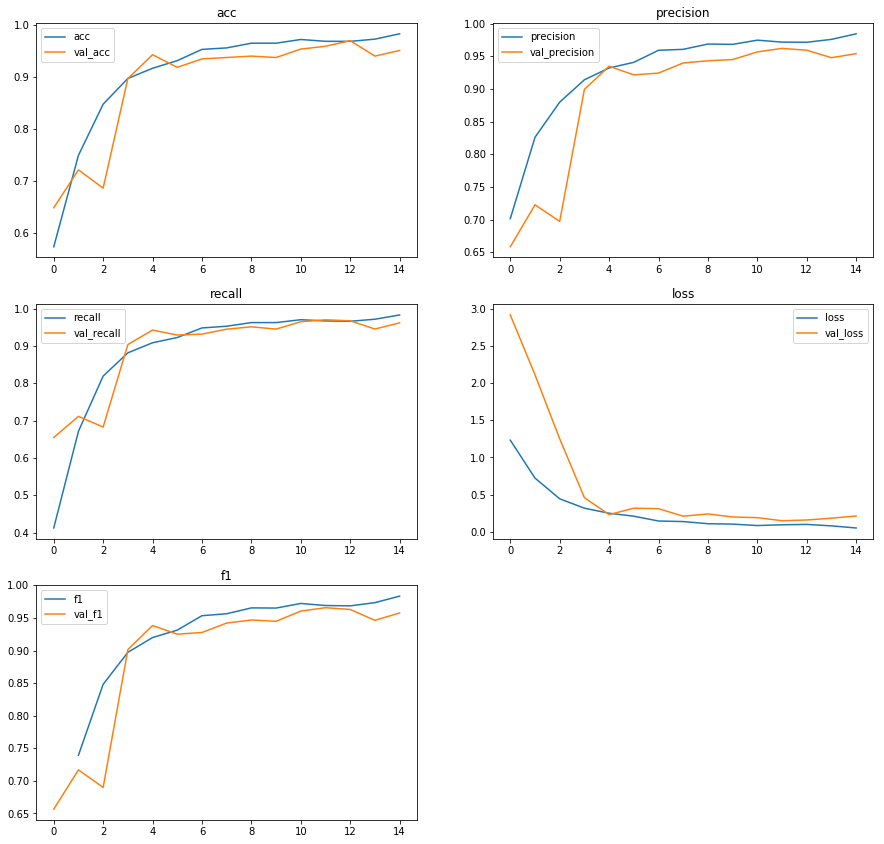

In [9]:
def plot_model(model):
    plots = [i for i in model.model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.model.history.history[p], label=p)
        plt.plot(model.model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [13]:
from keras.models import load_model

best_model = load_model('models/Model.h5', custom_objects={'recall': recall, 'precision': precision, 'f1': f1})

score, acc, recall, precision, f1 = best_model.evaluate(X_val, y_val, batch_size=64)

idx = len(results) + 1
results.loc[idx] = ['CNN - Transfer Learning', acc, precision, recall, f1]

print('Test score:', score)

results

 64/370 [====>.........................] - ETA: 1s

128/370 [=========>....................] - ETA: 0s

192/370 [==============>...............] - ETA: 0s

256/370 [===================>..........] - ETA: 0s

320/370 [========================>.....] - ETA: 0s

370/370 [==============================] - 0s     


Test score: 2.91540863147


,Model,Accuracy,Precision,Recall,F1
1,CNN - Transfer Learning,0.466125,0.471821,0.463415,NaN
2,CNN - Transfer Learning,0.648649,0.656777,0.659224,0.657689
